# Homework 2 Quentin GUIGNARD Maxime HANUS

## Exercise 1: Problem A

### Dataset Creation

<p>We use the make_blobs function from scikit-learn to generate a synthetic dataset. The dataset is configured as follows:<p>

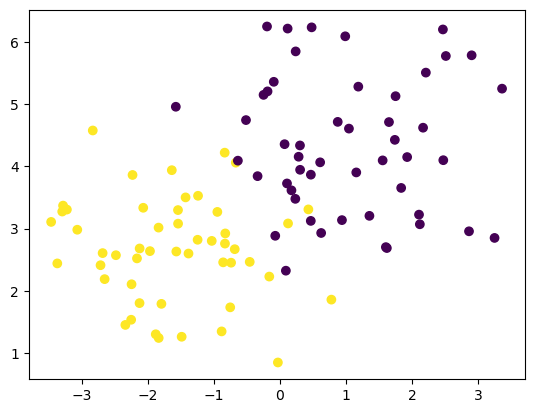

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=2, n_features=4, random_state=0)
y = y.reshape(-1, 1)
#display the data
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()


### Neural Network Design

The neural network used in this exercise has the following architecture:

- **Input Layer:** 4 neurons, corresponding to the four features of the dataset.

- **Hidden Layers:** Two layers, each with 16 neurons.

- **Output Layer:** 1 neuron, using a sigmoid activation function to output probabilities.

The sigmoid activation function is defined as:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$



#### **Functions in the Genetic Algorithm**

#### **`forward`**
Performs a forward pass through the neural network:
- Computes predictions using weights, biases, and the sigmoid activation function across layers:
$$
\hat{y} = \sigma(z) \quad \text{where} \quad \sigma(z) = \frac{1}{1 + e^{-z}}
$$

#### **`fitness`**
Calculates the fitness of an individual:
- Uses `forward` to compute predictions and returns the Mean Squared Error (MSE) compared to true labels:
$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
$$

#### **`tournament_selection`**
Implements tournament selection:
- Randomly picks \( k \) individuals from the population and returns the one with the best fitness.

#### **`crossover`**
Performs two-point crossover between two parents:
- Combines weights and biases from both parents to create an offspring by swapping values at two random indices.

#### **`mutate`**
Applies random mutations to an individual:
- Adds random noise to weights and biases with a probability defined by the mutation rate.

#### **`evolve`**
Manages the evolutionary process:
- Sorts individuals by fitness, retains the best (elitism), and generates a new population using selection, crossover, and mutation.
- Tracks the MSE over generations to monitor optimization progress.


In [39]:
class Neural_Network():

    def __init__(self, X, y, population_size=100, mutation_rate=0.1, num_generations=200, elitism_size=10):
        
        self.X = X
        self.y = y

        self.input_layer_size = 4
        self.output_layer_size = 1
        self.hidden_layers_size = 16

        # Initialize weights for each layer
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()

        self.num_generations = num_generations
        self.elitism_size = elitism_size

    def initialize_population(self):
        #Generate initial population with random weights
        population = []
        for _ in range(self.population_size):
            W1 = np.random.randn(self.input_layer_size, self.hidden_layers_size)
            W2 = np.random.randn(self.hidden_layers_size, self.hidden_layers_size)
            W3 = np.random.randn(self.hidden_layers_size, self.output_layer_size)
            B1 = np.random.randn(self.hidden_layers_size)
            B2 = np.random.randn(self.hidden_layers_size)
            B3 = np.random.randn(self.output_layer_size)
            population.append((W1, W2, W3, B1, B2, B3))
        return population
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def forward(self, X, individual):
        """
        Forward pass through the network\n
        X: input data\n
        individual: tuple of weights and biases\n
        \n
        Returns the predicted output
        """
        W1, W2, W3, B1, B2, B3 = individual
        self.z2 = np.dot(X, W1) + B1
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, W2) + B2
        self.a3 = self.sigmoid(self.z3)
        self.z4 = np.dot(self.a3, W3) + B3
        y_hat = self.sigmoid(self.z4)

        return y_hat
    
    def fitness(self, individual):
        """
        Calculate the fitness of an individual\n
        individual: tuple of weights and biases\n
        \n
        Returns the mean squared error
        """
        y_hat = self.forward(self.X, individual)
        return np.mean((self.y-y_hat)**2)
    
    def tournament_selection(self, k=3):
        """
        Selects the best individual from a random tournament\n
        k: number of individuals in the tournament\n
        \n
        Returns the best individual
        """
        indices = np.random.choice(len(self.population), k)
        tournament = [self.population[i] for i in indices]
        fitnesses = [self.fitness(ind) for ind in tournament]
        return tournament[np.argmin(fitnesses)]
    
    def crossover(self, parent1, parent2):
        """
        Crossover between two parents\n
        parent1: tuple of weights and biases\n
        parent2: tuple of weights and biases\n
        \n
        Returns the offspring
        """
        offspring = []
        for p1_layer, p2_layer in zip(parent1, parent2):
            p1_flat = p1_layer.flatten()
            p2_flat = p2_layer.flatten()
            if p1_flat.shape[0] != 1:
                idx1, idx2 = sorted(np.random.choice(len(p1_flat), 2, replace=False))
                child_flat = np.concatenate([p1_flat[:idx1], p2_flat[idx1:idx2], p1_flat[idx2:]])
                offspring.append(child_flat.reshape(p1_layer.shape))
            else:
                child_flat = np.random.choice([p1_flat[0], p2_flat[0]])
                offspring.append(child_flat)
        return tuple(offspring)
    
    def mutate(self, individual):
        """
        Mutates an individual\n
        individual: tuple of weights and biases\n
        \n
        Returns the mutated individual
        """
        mutated = []
        for layer in individual:
            mutated_layer = layer.copy()
            mutation_mask = np.random.rand(*layer.shape) < self.mutation_rate
            mutations = np.random.randn(*layer.shape) * mutation_mask
            mutated_layer += mutations
            mutated.append(mutated_layer)
        return tuple(mutated)
    
    def evolve(self):
        """
        Evolves the population for a number of generations\n
        \n
        Returns the best individual and the mean squared error history
        """
        
        mse_history = []

        for _ in range(self.num_generations):
            fitness_scores = [(individual, self.fitness(individual)) for individual in self.population]
            fitness_scores.sort(key=lambda x: x[1])
            new_population = [individual for individual, _ in fitness_scores[:self.elitism_size]]

            while len(new_population) < self.population_size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()
                child = self.crossover(parent1, parent2)
                mutated_child = self.mutate(child)
                new_population.append(mutated_child)
            
            self.population = new_population

            best_fitness = fitness_scores[0][1]
            mse_history.append(best_fitness)


        best_individual = fitness_scores[0][0]
        return best_individual, mse_history
    


In [40]:
nn = Neural_Network(X, y, population_size=100, mutation_rate=0.1, num_generations=200, elitism_size=10)
best_individual, mse_history = nn.evolve()
print(best_individual, mse_history)

(array([[ 0.88170199,  3.96270382, -0.91845651,  1.07914598,  4.01906544,
        -6.04801268,  1.16194479, -1.77021166,  1.04295401,  4.98729946,
         0.48865789,  2.18963299,  0.42235645, -2.16983199, -5.37644859,
         0.4902827 ],
       [ 2.32730679, -3.66142274,  1.97034281, -0.86759664, -0.91934825,
        -0.42197869, -6.12154588, -4.49820457,  0.60340984,  4.83620812,
        -1.40004753,  3.15936463, -0.43472197, -1.95701569, -3.40836379,
        -3.05948386],
       [ 2.4800052 , -5.65568574,  2.12173491, -5.73206624, -1.2752804 ,
        -3.16974285,  2.17838892, -4.22287406, -1.44639827,  1.81466437,
        -1.81092026,  0.76008192,  7.6249645 ,  2.20930774, -3.90839474,
        -2.29568031],
       [-2.27740335, -3.08470043, -2.23891362, -1.63836304,  5.04304206,
         0.53920155,  1.28823263,  1.94315699, -3.41184663, -2.76041915,
        -2.15947524, -4.82044406,  2.63207369, -0.61030998,  3.70787354,
         2.93892237]]), array([[ 4.53051399e+00, -6.20391

Visualization of the results

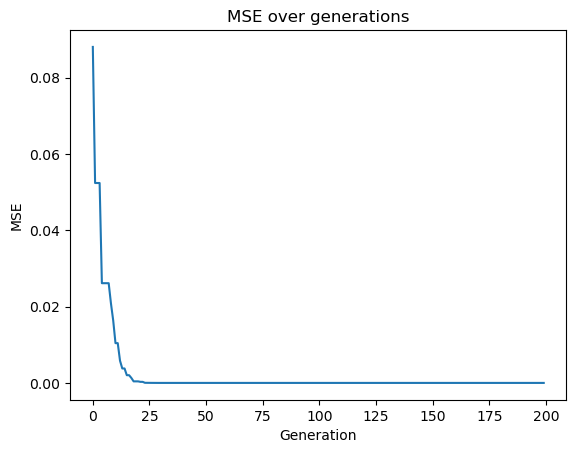

Final MSE of the best individual: 5.424160417948149e-124


In [42]:
# Plot the MSE history over generations using log function
plt.plot(mse_history)
plt.xlabel("Generation")
plt.ylabel("MSE")
plt.title("MSE over generations")
plt.show()


# Display the final MSE of the best individual
final_mse = nn.fitness(best_individual)
print(f"Final MSE of the best individual: {final_mse}")

We can highlight the effectiveness of the algorithm in reducing the MSE to near-zero levels.
At first there is a rapid learning, it converge very fast. After around 25 generations, the MSE levels off and approaches near-zero values.
This suggests that the algorithm has converged and reached an optimal or near-optimal solution.

### Discussion : Comparing different strategies

### Best mutation_rate

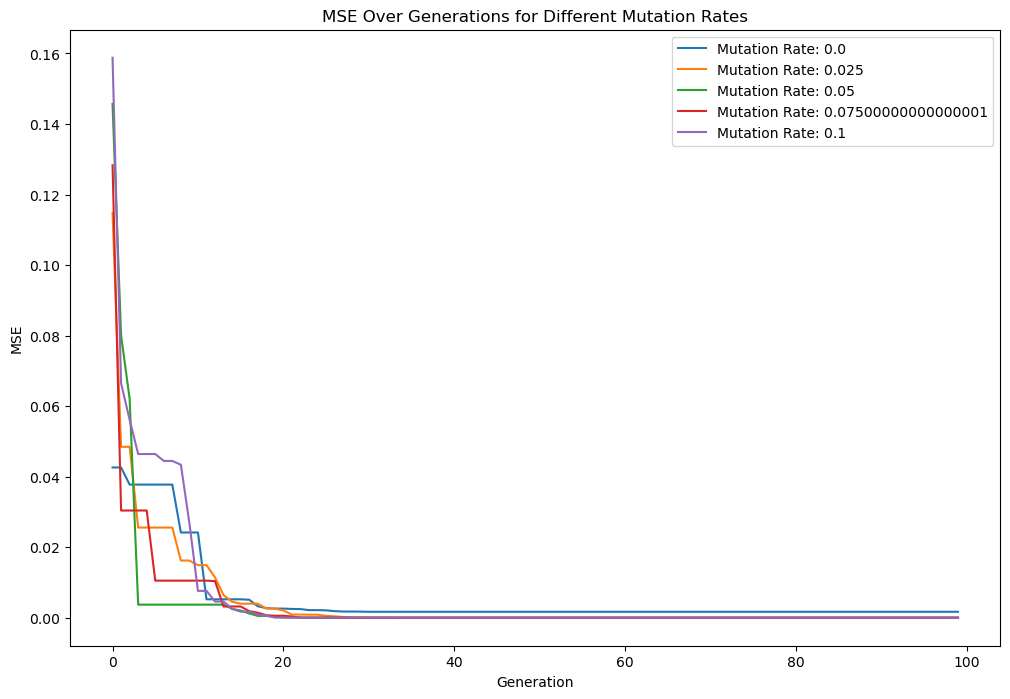

In [17]:
bests_mutations = []
for mutation_rate in np.linspace(0.00, 0.1, 5):
    nn = Neural_Network(X, y, population_size=100, mutation_rate=mutation_rate, num_generations=100, elitism_size=10)
    best_individual, mse_history = nn.evolve()
    bests_mutations.append((best_individual, mse_history))

# Plot the MSE history over generations for different mutation rates
plt.figure(figsize=(12, 8))
for best_individual, mse_history in bests_mutations:
    plt.plot(mse_history)
plt.xlabel('Generation')
plt.ylabel('MSE')
plt.title('MSE Over Generations for Different Mutation Rates')
plt.legend([f"Mutation Rate: {mutation_rate}" for mutation_rate in np.linspace(0.00, 0.1, 5)])
plt.show()

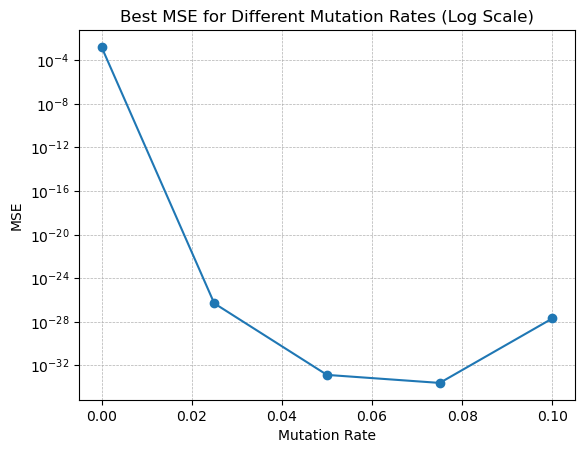

Mutation Rate: 0.0, Final MSE of the best individual: 0.0016856349089472782
Mutation Rate: 0.025, Final MSE of the best individual: 5.0033761665597064e-27
Mutation Rate: 0.05, Final MSE of the best individual: 1.3630966498225143e-33
Mutation Rate: 0.07500000000000001, Final MSE of the best individual: 2.5003759688663704e-34
Mutation Rate: 0.1, Final MSE of the best individual: 2.078483605241871e-28


In [27]:
# Best MSE for each mutation rate with logarithmic y-scale
best_mse = [mse[-1] for _, mse in bests_mutations]
plt.plot(np.linspace(0.00, 0.1, 5), best_mse, marker='o')
plt.xlabel('Mutation Rate')
plt.ylabel('MSE')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Best MSE for Different Mutation Rates (Log Scale)')
plt.grid(which='both', linestyle='--', linewidth=0.5)  # Optional: Add grid for clarity
plt.show()

# Display the final MSE of the best individual for each mutation rate
for mutation_rate, (best_individual, _) in zip(np.linspace(0.00, 0.1, 5), bests_mutations):
    final_mse = nn.fitness(best_individual)
    print(f"Mutation Rate: {mutation_rate}, Final MSE of the best individual: {final_mse}")


##### Summary of Mutation Rate Analysis

##### Key Observations:
- **Impact on Convergence**:
  - Mutation rates between **0.025 and 0.1** lead to faster convergence, achieving low MSE values within 20 generations.
  - A mutation rate of **0.0** results in significantly slower convergence, struggling to reach an optimal solution. This highlights the importance of mutations for exploring the solution space.

- **Final MSE Values**:
  - Mutation rates of **0.025 and higher** yield near-optimal final MSE values (effectively approaching zero).
  - A mutation rate of **0.0** results in a suboptimal final MSE of **0.00168**, indicating limited exploration capabilities.

- **Diminishing Returns**:
  - Mutation rates beyond **0.025** do not significantly improve the final MSE.
  - Higher mutation rates (e.g., **0.1**) achieve similar MSE results but introduce slight randomness in convergence patterns.



### Elitism_size

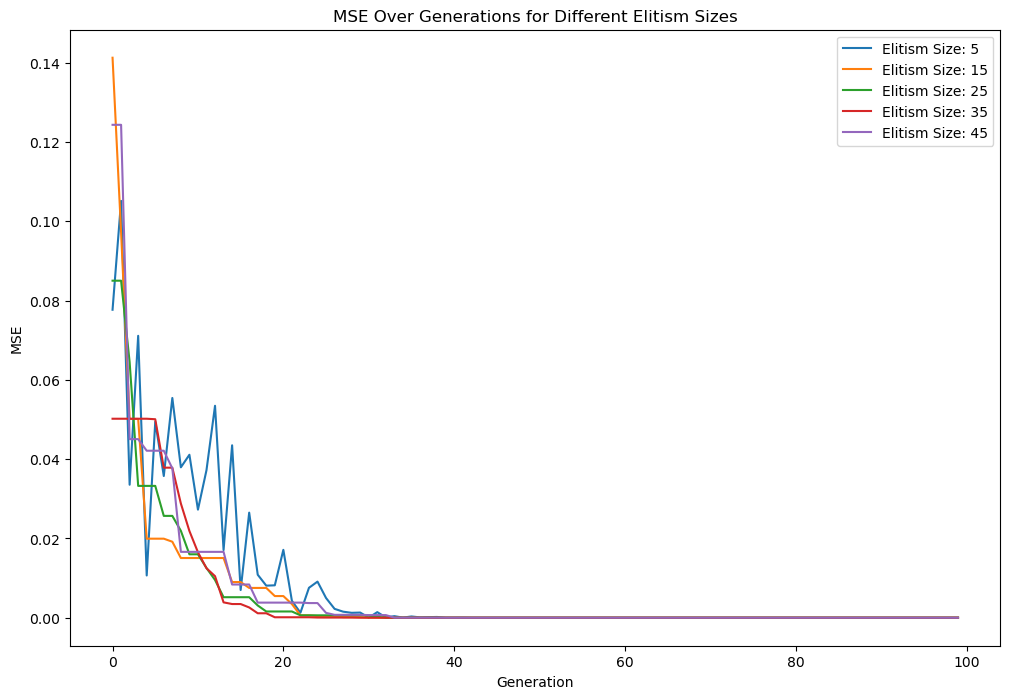

In [21]:
bests_elistism = []
for elitism_size in range(0, 50, 10):
    nn = Neural_Network(X, y, population_size=100, mutation_rate=0.1, num_generations=100, elitism_size=elitism_size)
    best_individual, mse_history = nn.evolve()
    bests_elistism.append((best_individual, mse_history))

# Plot the MSE history over generations for different elitism sizes
plt.figure(figsize=(12, 8))
for best_individual, mse_history in bests_elistism:
    plt.plot(mse_history)
plt.xlabel('Generation')
plt.ylabel('MSE')
plt.title('MSE Over Generations for Different Elitism Sizes')
plt.legend([f"Elitism Size: {elitism_size}" for elitism_size in range(5, 50, 10)])
plt.show()

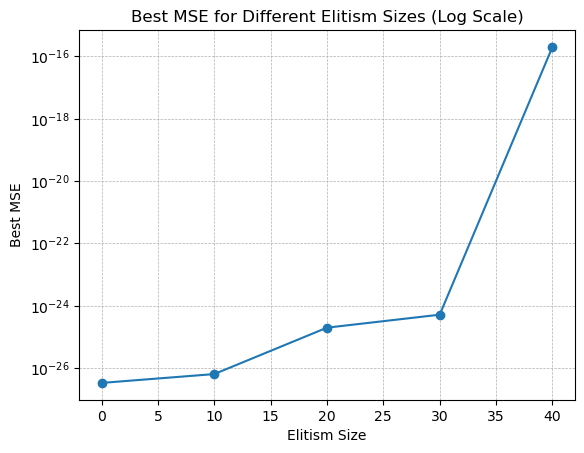

Elitism Size: 0, Best MSE: 3.3264849588234146e-27
Elitism Size: 10, Best MSE: 6.4012827748830094e-27
Elitism Size: 20, Best MSE: 1.9762020692225806e-25
Elitism Size: 30, Best MSE: 5.150330342170211e-25
Elitism Size: 40, Best MSE: 2.0253700506902814e-16


In [26]:
bests_elistism_mse = []
for best in bests_elistism:
    bests_elistism_mse.append(min(best[1]))

# Plot the best MSE for each elitism size with a logarithmic scale
plt.plot(range(0, 50, 10), bests_elistism_mse, marker='o')  # Added marker for better visibility
plt.xlabel('Elitism Size')
plt.ylabel('Best MSE')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Best MSE for Different Elitism Sizes (Log Scale)')
plt.grid(which='both', linestyle='--', linewidth=0.5)  # Optional: Add grid for clarity
plt.show()

# Print the best MSE for each elitism size
for i, best_mse in enumerate(bests_elistism_mse):
    print(f"Elitism Size: {0 + i*10}, Best MSE: {best_mse}")


##### Analysis of Elitism Size on MSE

##### Key Observations:
1. **Impact of Elitism on Convergence**:
   - Higher elitism sizes reduce diversity within the population, leading to slower convergence and possible early stagnation.
   - Lower elitism sizes (e.g., 5 and 15) show faster early convergence but slightly worse final performance compared to moderate elitism sizes.

2. **Best MSE for Elitism Sizes**:
   - The lowest MSE is achieved at an elitism size of 0, as shown in the log-scale plot. The performance stabilizes for elitism sizes up to 20.
   - Beyond an elitism size of 30, the MSE increases significantly due to reduced population diversity.

3. **Trade-offs**:
   - Smaller elitism sizes encourage exploration, leading to faster convergence early on but may result in slightly higher final MSE.
   - Larger elitism sizes preserve high-performing solutions, but this comes at the expense of slower convergence and higher stagnation risk.


#### Graphs:
- **MSE Over Generations**:
  The progression of MSE for different elitism sizes shows that smaller sizes (e.g., 5, 15) tend to converge faster initially but stabilize at slightly higher MSE values.
- **Log-Scale Best MSE**:
  The log-scale plot demonstrates significant MSE improvements for smaller elitism sizes, while elitism sizes larger than 20 result in diminishing returns and increased MSE.


### Population size

In [31]:
bests = []
for population_size in range(50, 550, 100):
    nn = Neural_Network(X, y, population_size=population_size, mutation_rate=0.1, num_generations=200, elitism_size = population_size//10) # Elitism size is 10% of population size so that it scales with population size
    best_individual, mse_history = nn.evolve()
    final_mse = nn.fitness(best_individual)
    bests.append((population_size, final_mse))
    print(f"Population Size: {population_size}, Final MSE: {final_mse}")

Population Size: 50, Final MSE: 1.3158399615802162e-83
Population Size: 150, Final MSE: 1.3137732877108817e-151
Population Size: 250, Final MSE: 1.100982757698317e-155
Population Size: 350, Final MSE: 2.207631068417264e-208
Population Size: 450, Final MSE: 1.7537906570098815e-201


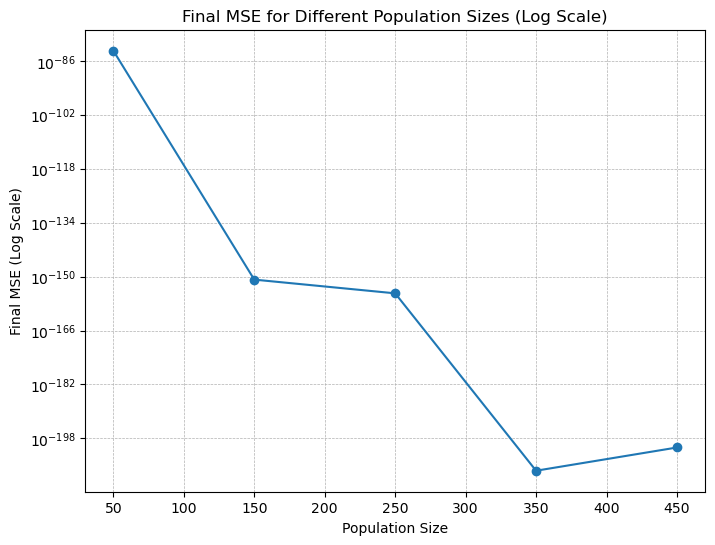

In [32]:
population_sizes, final_mse_values = zip(*bests)

plt.figure(figsize=(8, 6))
plt.plot(population_sizes, final_mse_values, marker='o')
plt.yscale('log')  # Logarithmic scale for MSE values
plt.xlabel('Population Size')
plt.ylabel('Final MSE (Log Scale)')
plt.title('Final MSE for Different Population Sizes (Log Scale)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

##### Population Size Impact on Final MSE

The plot shows the final MSE values across different population sizes (on a logarithmic scale). 

- **Smaller Population Sizes (50–150):** Higher MSE due to limited diversity in solutions.
- **Medium Population Sizes (150–300):** Significant improvement as population size increases.
- **Larger Population Sizes (350–450):** Plateauing improvements, with some marginal increases in MSE at 450.

##### Conclusion:
While larger population sizes help reduce MSE, the optimal balance between computational efficiency and performance seems to occur around a population size of 300–350. Because the larger the population size, the longer it takes the code to run


### Different selection techniques

In [33]:
class Neural_Network():

    def __init__(self, X, y, population_size=100, mutation_rate=0.1, num_generations=200, elitism_size=10, selection_type='tournament'):
        
        self.X = X
        self.y = y

        self.input_layer_size = 4
        self.output_layer_size = 1
        self.hidden_layers_size = 16

        # Initialize weights for each layer
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.population = self.initialize_population()

        self.num_generations = num_generations
        self.elitism_size = elitism_size
        self.selection_type = selection_type

    def initialize_population(self):
        #Generate initial population with random weights
        population = []
        for _ in range(self.population_size):
            W1 = np.random.randn(self.input_layer_size, self.hidden_layers_size)
            W2 = np.random.randn(self.hidden_layers_size, self.hidden_layers_size)
            W3 = np.random.randn(self.hidden_layers_size, self.output_layer_size)
            B1 = np.random.randn(self.hidden_layers_size)
            B2 = np.random.randn(self.hidden_layers_size)
            B3 = np.random.randn(self.output_layer_size)
            population.append((W1, W2, W3, B1, B2, B3))
        return population
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def forward(self, X, individual):
        W1, W2, W3, B1, B2, B3 = individual
        self.z2 = np.dot(X, W1) + B1
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, W2) + B2
        self.a3 = self.sigmoid(self.z3)
        self.z4 = np.dot(self.a3, W3) + B3
        y_hat = self.sigmoid(self.z4)

        return y_hat
    
    def fitness(self, individual):
        y_hat = self.forward(self.X, individual)
        return np.mean((self.y-y_hat)**2)
    
    def roulette_wheel_selection(self):
        fitness_scores = [self.fitness(ind) for ind in self.population]
        fitness_scores = np.array(fitness_scores)
        fitness_scores = 1 / (fitness_scores + 1e-6)  # Add small value to avoid division by zero
        probabilities = fitness_scores / np.sum(fitness_scores)
        return self.population[np.random.choice(len(self.population), p=probabilities)]
    
    def tournament_selection(self, k=3):
        indices = np.random.choice(len(self.population), k)
        tournament = [self.population[i] for i in indices]
        fitnesses = [self.fitness(ind) for ind in tournament]
        return tournament[np.argmin(fitnesses)]

    def rank_based_selection(self):
        fitness_scores = [self.fitness(ind) for ind in self.population]
        fitness_scores = np.array(fitness_scores)
        ranks = np.argsort(fitness_scores)
        probabilities = ranks / np.sum(ranks)
        return self.population[np.random.choice(len(self.population), p=probabilities)]
    
    def crossover(self, parent1, parent2):
        offspring = []
        for p1_layer, p2_layer in zip(parent1, parent2):
            p1_flat = p1_layer.flatten()
            p2_flat = p2_layer.flatten()
            if p1_flat.shape[0] != 1:
                idx1, idx2 = sorted(np.random.choice(len(p1_flat), 2, replace=False))
                child_flat = np.concatenate([p1_flat[:idx1], p2_flat[idx1:idx2], p1_flat[idx2:]])
                offspring.append(child_flat.reshape(p1_layer.shape))
            else:
                child_flat = np.random.choice([p1_flat[0], p2_flat[0]])
                offspring.append(child_flat)
        return tuple(offspring)
    
    def mutate(self, individual):
        mutated = []
        for layer in individual:
            mutated_layer = layer.copy()
            mutation_mask = np.random.rand(*layer.shape) < self.mutation_rate
            mutations = np.random.randn(*layer.shape) * mutation_mask
            mutated_layer += mutations
            mutated.append(mutated_layer)
        return tuple(mutated)
    
    def evolve(self):
        mse_history = []
        for generation in range(self.num_generations):
            fitness_scores = [(individual, self.fitness(individual)) for individual in self.population]
            fitness_scores.sort(key=lambda x: x[1])
            new_population = [individual for individual, _ in fitness_scores[:self.elitism_size]]

            while len(new_population) < self.population_size:
                if(self.selection_type == 'tournament'):
                    parent1 = self.tournament_selection()
                    parent2 = self.tournament_selection()
                elif self.selection_type == 'roulette_wheel':
                    parent1 = self.roulette_wheel_selection()
                    parent2 = self.roulette_wheel_selection()
                else:
                    parent1 = self.rank_based_selection()
                    parent2 = self.rank_based_selection()
                child = self.crossover(parent1, parent2)
                mutated_child = self.mutate(child)
                new_population.append(mutated_child)
            
            self.population = new_population

            best_fitness = fitness_scores[0][1]
            mse_history.append(best_fitness)

            #print(f"Generation {generation + 1}/{self.num_generations}, Best Fitness (MSE): {best_fitness}, population size: {len(self.population)}")

        best_individual = fitness_scores[0][0]
        return best_individual, mse_history
    


In [35]:
nn = Neural_Network(X, y, population_size=100, mutation_rate=0.1, num_generations=50, elitism_size=10, selection_type='tournament')
nn1 = Neural_Network(X, y, population_size=100, mutation_rate=0.1, num_generations=50, elitism_size=10, selection_type='roulette_wheel')
nn2 = Neural_Network(X, y, population_size=100, mutation_rate=0.1, num_generations=50, elitism_size=10, selection_type='rank_based')

import time 
start = time.time()
best_individual, mse_history = nn.evolve()
end = time.time()
print(f"Time taken for tournament selection: {end - start} seconds")
print('Best MSE for tournament selection:', mse_history[-1])

start = time.time()
best_individual, mse_history = nn1.evolve()
end = time.time()
print(f"Time taken for roulette wheel selection: {end - start} seconds")
print('Best MSE for roulette selection:', mse_history[-1])

start = time.time()
best_individual, mse_history = nn2.evolve()
end = time.time()
print(f"Time taken for rank based selection: {end - start} seconds")
print('Best MSE for rank based selection:', mse_history[-1])

Time taken for tournament selection: 3.160778284072876 seconds
Best MSE for tournament selection: 4.1430775347234093e-13
Time taken for roulette wheel selection: 63.343191385269165 seconds
Best MSE for roulette selection: 7.0689169749410005e-15
Time taken for rank based selection: 56.16155648231506 seconds
Best MSE for rank based selection: 0.009011094041577735


##### Comparison of Selection Methods in Genetic Algorithm


##### Observations:
- **Tournament Selection** is the fastest, achieving a reasonable MSE but not as competitive as the other methods in accuracy.
- **Roulette Wheel Selection** takes significantly longer, likely due to its computational intensity for probabilistic weighting, but achieves a slightly better MSE than tournament selection.
- **Rank-Based Selection** strikes a balance between performance and accuracy, offering the lowest final MSE, though at the cost of higher computation time compared to tournament selection.

##### Conclusion:
For applications prioritizing **execution time**, tournament selection is recommended. If **accuracy** is more critical, rank-based selection offers the best trade-off between time and performance.


### Gradient Descent

In [37]:
import numpy as np

class NeuralNetworkGD:
    def __init__(self, X, y, learning_rate=0.01, num_iterations=1000):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations

        # Network dimensions
        self.input_layer_size = X.shape[1]
        self.hidden_layer1_size = 16
        self.hidden_layer2_size = 16
        self.output_layer_size = 1

        # Initialize weights and biases
        self.W1 = np.random.randn(self.input_layer_size, self.hidden_layer1_size)
        self.b1 = np.random.randn(self.hidden_layer1_size)
        self.W2 = np.random.randn(self.hidden_layer1_size, self.hidden_layer2_size)
        self.b2 = np.random.randn(self.hidden_layer2_size)
        self.W3 = np.random.randn(self.hidden_layer2_size, self.output_layer_size)
        self.b3 = np.random.randn(self.output_layer_size)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        sig = self.sigmoid(z)
        return sig * (1 - sig)

    def forward(self, X):
        # Forward pass through the first hidden layer
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)

        # Forward pass through the second hidden layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)

        # Output layer
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        y_hat = self.sigmoid(self.z3)
        
        return y_hat

    def compute_loss(self, y_hat):
        return np.mean((self.y - y_hat) ** 2)

    def backpropagate(self, y_hat):
        # Gradient of the loss w.r.t y_hat
        d_loss_yhat = 2 * (y_hat - self.y) / self.y.size

        # Gradients for output layer
        d_yhat_z3 = self.sigmoid_derivative(self.z3)
        d_loss_z3 = d_loss_yhat * d_yhat_z3

        d_loss_W3 = np.dot(self.a2.T, d_loss_z3)
        d_loss_b3 = np.sum(d_loss_z3, axis=0)

        # Gradients for the second hidden layer
        d_loss_a2 = np.dot(d_loss_z3, self.W3.T)
        d_a2_z2 = self.sigmoid_derivative(self.z2)
        d_loss_z2 = d_loss_a2 * d_a2_z2

        d_loss_W2 = np.dot(self.a1.T, d_loss_z2)
        d_loss_b2 = np.sum(d_loss_z2, axis=0)

        # Gradients for the first hidden layer
        d_loss_a1 = np.dot(d_loss_z2, self.W2.T)
        d_a1_z1 = self.sigmoid_derivative(self.z1)
        d_loss_z1 = d_loss_a1 * d_a1_z1

        d_loss_W1 = np.dot(self.X.T, d_loss_z1)
        d_loss_b1 = np.sum(d_loss_z1, axis=0)

        return d_loss_W1, d_loss_b1, d_loss_W2, d_loss_b2, d_loss_W3, d_loss_b3

    def gradient_descent_step(self, dW1, db1, dW2, db2, dW3, db3):
        # Update weights and biases
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W3 -= self.learning_rate * dW3
        self.b3 -= self.learning_rate * db3

    def train(self):
        loss_history = []

        for i in range(self.num_iterations):
            # Forward pass
            y_hat = self.forward(self.X)
            loss = self.compute_loss(y_hat)
            loss_history.append(loss)

            # Backward pass
            dW1, db1, dW2, db2, dW3, db3 = self.backpropagate(y_hat)

            # Gradient descent step
            self.gradient_descent_step(dW1, db1, dW2, db2, dW3, db3)

        return loss_history, self.W1, self.b1, self.W2, self.b2, self.W3, self.b3

# Example usage (assuming X and y are defined)
# Generate synthetic data
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=2, n_features=4, random_state=0)
y = y.reshape(-1, 1)  # Reshape y to be (n_samples, 1)
y = (y == y.max(axis=0)).astype(int)  # Binary target

# Train with gradient descent

nn_gd = NeuralNetworkGD(X, y, learning_rate=0.2, num_iterations=10000)
start = time.time()
loss_history, W1, b1, W2, b2, W3, b3 = nn_gd.train()
end = time.time()
print(f"Time taken for gradient descent: {end - start} seconds")
print('Final loss:', loss_history[-1])


Time taken for gradient descent: 1.6691114902496338 seconds
Final loss: 9.821931332630752e-05


**Gradient descent** is the fastest method with the shortest runtime, making it suitable for tasks where computational efficiency is critical.

But will need a lot more generation for it reduce the mse as the **Genetic Algorithm**

#### Advantages and Limitations of Using Genetic Algorithms (GAs) for Neural Network Optimization

#### Advantages:
- **Global Optimization:** GAs reduce the risk of getting stuck in local minima, making them ideal for non-convex problems.
- **Flexible Parameter Search:** Can optimize weights, architecture, and hyperparameters simultaneously.
- **Robustness and Parallelism:** Less sensitive to initialization and easily parallelizable.

#### Limitations:
- **Slow Convergence:** Stochastic nature makes convergence slower compared to gradient-based methods.
- **Scaling Issues:** Performance drops with large networks or search spaces. (i.e population size)
- **Limited Fine-Tuning:** GAs may find near-optimal solutions but lack precision in fine-tuning.

In essence, GAs are powerful for global, gradient-free optimization but often less efficient than gradient-based approaches for standard neural network training.


# Exercise 2 : Battleship Solitaire Puzzle

### Challenges Encountered During the Implementation of the Battleship CSP Solver

Implementing the Battleship Solitaire solver using Constraint Satisfaction Problem (CSP) techniques was both a rewarding and demanding experience. Below, I outline the primary challenges I faced and the lessons learned during the process.

---

#### Key Challenges

1. **Debugging Issues:**
   - Debugging the solver was one of the most time-consuming aspects of this project. Whenever the program failed to find a solution, identifying the root cause was not straightforward. This was especially challenging given the random placement of moves, which made reproducing errors and isolating bugs more complex.

2. **Designing a Flexible Class Structure:**
   - I had to refactor the CSP class multiple times to ensure compatibility with AC-3, forward checking, and heuristics like MRV and Degree. Initially, the class design made implementing these techniques difficult. I later realized that this was partly due to my initial misinterpretation of the problem's requirements. Refactoring the class to handle all these functionalities while maintaining clarity and scalability required significant effort.

3. **Implementing Ship Placement Constraints:**
   - Deciding what was allowed or disallowed for ship placement involved carefully translating the game rules into constraints. This included:
     - Ensuring ships did not touch each other, even diagonally.
     - Respecting row and column segment counts.
     - Managing fleet constraints, ensuring the correct number of each type of ship was placed.
   - The difficulty lay in ensuring that all constraints worked together harmoniously, without unintended side effects.

4. **Globalizing Code Changes:**
   - A recurring issue was making changes to the code to solve a specific example, only to discover that the changes broke functionality for other examples. This forced me to focus on creating solutions that worked across all scenarios rather than just individual cases. Testing on multiple grids became essential to verify the solver's correctness.

5. **Handling Randomized Assignments:**
   - Random placements made it challenging to identify and debug specific issues. While the randomness helped explore the solution space, it introduced variability that made testing and debugging harder. Tracing issues in large grids with randomized moves required additional tools and systematic debugging strategies.

6. **Correcting Minor Errors Across the Codebase:**
   - With a large number of lines of code, even small mistakes (e.g., off-by-one errors, incorrect domain updates, misplaced constraints or even wrong tipping) could cause significant problems. Tracking and fixing these minor errors, especially when they had cascading effects, required a lot of attention to detail.




In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import random

class BattleShipCSP:


    #Initialisation
    def __init__(self, file_path,domains = None):
        puzzle_info = pd.read_csv(file_path, header=None)
        vertical_constraints = puzzle_info.iloc[0, :].values
        horizontal_constraints = puzzle_info.iloc[1, :].values
        nb_ships = puzzle_info.iloc[2, :].values

        self.vertical_constraints = np.array([elm for elm in vertical_constraints[0]]).astype(int)
        self.horizontal_constraints = np.array([elm for elm in horizontal_constraints[0]]).astype(int)
        self.nb_ships = np.array([elm for elm in nb_ships[0]]).astype(int)
        self.nb_ships_initial = self.nb_ships.copy()

        puzzle_board = puzzle_info.iloc[3:, :].applymap(str).values
        self.puzzle_board = np.array([list(row) for row in puzzle_board.flatten()])

        self.possible_values = ['S','<','>','^','v','M','.']
        self.dico_pts = {'S': 1, '.': 0, '<': 1, '>': 1, '^': 1, 'v': 1, 'M': 1}

        if domains is None:
            self.variables = [(i, j) for i in range(self.puzzle_board.shape[0]) for j in range(self.puzzle_board.shape[1])]
            self.domains = {var: self.possible_values[:] for var in self.variables}
            self.fill_domains()
        else:
            self.domains = domains
                
        self.nodes_explored = 0
        self.nodes_expanded = 0

        self.ac3_done = True

    def fill_domains(self): 
        for i in range(self.puzzle_board.shape[0]):
            for j in range(self.puzzle_board.shape[1]):
                if self.puzzle_board[i][j] != '0':
                    self.forward_check((i, j), self.puzzle_board[i][j])

    # Get different neighbors of a position
    def get_neighbors_diago(self, pos, place):
        """
        Renvoie un liste des voisins en diagonale de la position pos
        """
        neighbors = []
        x,y = pos
        if 'top' in place and 'left' in place:
            neighbors.append(self.puzzle_board[x+1][y+1])
        elif 'top' in place and 'right' in place:
            neighbors.append(self.puzzle_board[x+1][y-1])
        elif 'bottom' in place and 'left' in place:
            neighbors.append(self.puzzle_board[x-1][y+1])
        elif 'bottom' in place and 'right' in place:
            neighbors.append(self.puzzle_board[x-1][y-1])
        elif 'top' in place:
            neighbors.append(self.puzzle_board[x+1][y+1])
            neighbors.append(self.puzzle_board[x+1][y-1])
        elif 'bottom' in place:
            neighbors.append(self.puzzle_board[x-1][y+1])
            neighbors.append(self.puzzle_board[x-1][y-1])
        elif 'left' in place:
            neighbors.append(self.puzzle_board[x+1][y+1])
            neighbors.append(self.puzzle_board[x-1][y+1])
        elif 'right' in place:
            neighbors.append(self.puzzle_board[x+1][y-1])
            neighbors.append(self.puzzle_board[x-1][y-1])
        elif 'middle' in place:
            neighbors.append(self.puzzle_board[x+1][y+1])
            neighbors.append(self.puzzle_board[x+1][y-1])
            neighbors.append(self.puzzle_board[x-1][y+1])
            neighbors.append(self.puzzle_board[x-1][y-1])

        return neighbors
    
    def get_neighbors(self, pos, direction, distance, move = None):
        """
        renvoie le voisin de la position pos dans la direction donnée
        """
        neighbor = ""
        x,y = pos
        if direction == 'up' and x-distance >= 0:
            neighbor = self.puzzle_board[x-distance][y]

        elif direction == 'down' and x+distance < self.puzzle_board.shape[0]:
                neighbor = self.puzzle_board[x+distance][y]

        elif direction == 'left' and y-distance >= 0:
            neighbor = self.puzzle_board[x][y-distance]

        elif direction == 'right' and y+distance < self.puzzle_board.shape[1]:
                neighbor = self.puzzle_board[x][y+distance]
        return neighbor

    def get_all_neighbors(self, pos):
        """
        renvoie la liste des voisins de la position pos
        """
        neighbors = []
        x,y = pos
        if x-1 >= 0:
            neighbors.append(self.puzzle_board[x-1][y])
        if x+1 < self.puzzle_board.shape[0]:
            neighbors.append(self.puzzle_board[x+1][y])
        if y-1 >= 0:
            neighbors.append(self.puzzle_board[x][y-1])
        if y+1 < self.puzzle_board.shape[1]:
            neighbors.append(self.puzzle_board[x][y+1])
        
        #diagonals
        if x-1 >= 0 and y-1 >= 0:
            neighbors.append(self.puzzle_board[x-1][y-1])
        if x-1 >= 0 and y+1 < self.puzzle_board.shape[1]:
            neighbors.append(self.puzzle_board[x-1][y+1])
        if x+1 < self.puzzle_board.shape[0] and y-1 >= 0:
            neighbors.append(self.puzzle_board[x+1][y-1])
        if x+1 < self.puzzle_board.shape[0] and y+1 < self.puzzle_board.shape[1]:
            neighbors.append(self.puzzle_board[x+1][y+1])


        return neighbors

    def get_pos_neighbors(self, pos):
        """
        renvoie la liste des positions voisines de la position pos
        """
        neighbors = []
        x,y = pos
        if x-1 >= 0:
            neighbors.append((x-1, y))
        if x+1 < self.puzzle_board.shape[0]:
            neighbors.append((x+1, y))
        if y-1 >= 0:
            neighbors.append((x, y-1))
        if y+1 < self.puzzle_board.shape[1]:
            neighbors.append((x, y+1))
        
        #diagonals
        if x-1 >= 0 and y-1 >= 0:
            neighbors.append((x-1, y-1))
        if x-1 >= 0 and y+1 < self.puzzle_board.shape[1]:
            neighbors.append((x-1, y+1))
        if x+1 < self.puzzle_board.shape[0] and y-1 >= 0:
            neighbors.append((x+1, y-1))
        if x+1 < self.puzzle_board.shape[0] and y+1 < self.puzzle_board.shape[1]:
            neighbors.append((x+1, y+1))

        return neighbors

    #Constraint check
    def validate_ship_placement(self, pos, move, nb_ships_left):
        if not self.ac3_done:
            nb_ships_left = self.nb_ships_initial
        """
        Vérifie si le placement d'un mouvement 'move' est valide en fonction des bateaux restants et des voisins.
        Renvoie False si le placement est invalide, True si valide.
        """
        # Variables pour les voisins
        right_neighbors = self.get_neighbors(pos, 'right', 1)
        two_cell_right = self.get_neighbors(pos, 'right', 2)
        three_cell_right = self.get_neighbors(pos, 'right', 3)
        
        left_neighbors = self.get_neighbors(pos, 'left', 1)
        two_cell_left = self.get_neighbors(pos, 'left', 2)
        three_cell_left = self.get_neighbors(pos, 'left', 3)
        
        up_neighbors = self.get_neighbors(pos, 'up', 1)
        two_cell_up = self.get_neighbors(pos, 'up', 2)
        three_cell_up = self.get_neighbors(pos, 'up', 3)
        
        down_neighbors = self.get_neighbors(pos, 'down', 1)
        two_cell_down = self.get_neighbors(pos, 'down', 2)
        three_cell_down = self.get_neighbors(pos, 'down', 3)

        # Fonction de vérification par direction

        def check_direction(neighbor1, neighbor2, neighbor3, direction_ships_left,move):
            """
            Vérifie si le placement d'un mouvement 'move' est valide en fonction des bateaux restants et des voisins.
            Renvoie False si le placement est invalide, True si valide.
            """
            if move == '>':
                opposite_move = '<'
            elif move == '<':
                opposite_move = '>'
            elif move == '^':
                opposite_move = 'v'
            elif move == 'v':
                opposite_move = '^'
            if direction_ships_left[1] == 0 and direction_ships_left[2] == 0 and direction_ships_left[3] == 0:
                return False
            if direction_ships_left[1] == 0:
                if neighbor1 == opposite_move:
                    return False
                if neighbor1 == '0' and neighbor2 in ['.', '']:
                    return False
            if direction_ships_left[2] == 0:
                if neighbor1 in ['M', '0'] and neighbor2 == opposite_move:
                    return False
                if neighbor1 == 'M' and neighbor2 == '0' and neighbor3 in ['.','']:
                    return False
            if direction_ships_left[3] == 0:
                if neighbor1 in ['M', '0'] and neighbor2 in ['M', '0'] and neighbor3 == opposite_move:
                    return False
                if ((neighbor1 == '0' and neighbor2 == 'M') or (neighbor1 == 'M' and neighbor2 == 'M')) and neighbor3 == '0':
                    return False
            return True

        # Vérification de chaque direction en utilisant la fonction
        if move == '<':
            return check_direction(right_neighbors, two_cell_right, three_cell_right, nb_ships_left,move)
        elif move == '>':
            return check_direction(left_neighbors, two_cell_left, three_cell_left, nb_ships_left,move)
        elif move == '^':
            return check_direction(down_neighbors, two_cell_down, three_cell_down, nb_ships_left,move)
        elif move == 'v':
            return check_direction(up_neighbors, two_cell_up, three_cell_up, nb_ships_left,move)
        elif move == 'S':
            return nb_ships_left[0] > 0

        return True

    def check_constraint(self, move, pos):
        """
        Vérifie si le mouvement 'move' est valide à la position 'pos'.
        """
        #print(pos, move)
        nb_ships_actual = self.check_nb_ships()
        nb_ships_left = self.nb_ships_initial-nb_ships_actual

        for ships in nb_ships_left:
            if ships < 0:
                #print("Error: More ships placed than expected.")
                return False
            
        x = pos[0]
        y = pos[1]

        # Check vertical and horizontal constraints
        count_vert = 0
        possible_vert = self.dico_pts[move]-1
        for i in range(0,self.puzzle_board.shape[0]):
            if(self.puzzle_board[i][y] != '0'):
                count_vert += self.dico_pts[self.puzzle_board[i][y]]
            else:
                possible_vert += 1

        if(count_vert > self.vertical_constraints[y] or count_vert + possible_vert < self.vertical_constraints[y]): 
            return False
        count_hor = 0
        possible_hor = self.dico_pts[move]-1
        for i in range(0,self.puzzle_board.shape[1]):
            if(self.puzzle_board[x][i] != '0'):
                count_hor += self.dico_pts[self.puzzle_board[x][i]]
            else:
                possible_hor += 1
        if(count_hor > self.horizontal_constraints[x] or count_hor + possible_hor < self.horizontal_constraints[x]):
            return False
        

        # Check if placable, I want to know where the ship part is placed to check the neighbors
        place = []
        if abs(x-self.puzzle_board.shape[0]+1) == 0:
                place.append("bottom")
                #bord bas
        if(x == 0):
                place.append("top")
                #bord haut
        if y == 0:
            place.append("left")
            #bord gauche
        if(abs(y-self.puzzle_board.shape[1]+1) == 0):
            place.append("right")
            #bord droit
        if place == []:
            place.append("middle")

            #au milieu

        #for the perimeter
        if 'top' in place and move == 'v':
            return False
        if 'bottom' in place and move == '^':
            return False
        if 'left' in place and move == '>':
            return False
        if 'right' in place and move == '<':
            return False
        

        #print("perimeter check")
        diag_neighbors = self.get_neighbors_diago(pos, place)
        up_neighbors = self.get_neighbors(pos, 'up',1)
        down_neighbors = self.get_neighbors(pos, 'down',1)
        left_neighbors = self.get_neighbors(pos, 'left',1, move)
        right_neighbors = self.get_neighbors(pos, 'right',1)
        #print("neighbors",left_neighbors, right_neighbors, up_neighbors, down_neighbors, "place", place)

        #check ships constraints
        if not(self.validate_ship_placement(pos, move, nb_ships_left)):
            #print("ships pb")
            return False

        #check of diagonal neighbors they must be empty or water if mowe is not water
        for neighbor in diag_neighbors:
            if neighbor != '0' and neighbor != '.' and move !='.':
                #print("diag pb")
                return False
            
        # On this part we check the neighbors of the position to see if the move is valid

        # Check Left
        if "right" not in place:
            if move in ['S', '^', 'v', '>']:
                if right_neighbors not in ['0', '.']:
                    return False
            if move == '<':
                if right_neighbors in ['S', '^', 'v', '.']:
                    return False
                elif right_neighbors != '>':
                    if right_neighbors == 'M':
                        if self.in_bounds(x, y+2):
                            if self.puzzle_board[x][y+2] not in ['>', 'M', '0']:
                                return False
                            elif self.puzzle_board[x][y+2] == 'M':
                                if self.in_bounds(x, y+3):
                                    if self.puzzle_board[x][y+3] not in ['>','0']:
                                        return False
                                else:
                                    return False
                            elif self.puzzle_board[x][y+2] == '0':
                                if self.in_bounds(x, y+3):
                                    if self.puzzle_board[x][y+3] not in ['>','0','.']:
                                        return False
                            elif self.puzzle_board[x][y+2] == '>':
                                if self.in_bounds(x, y+3):
                                    if self.puzzle_board[x][y+3] not in ['0','.']:
                                        return False
                        else:
                            return False
                    if right_neighbors == '0':
                        if self.in_bounds(x, y+2):
                            if self.puzzle_board[x][y+2] not in ['M','>','0','.']:
                                return False
                            elif self.puzzle_board[x][y+2] == '>':
                                if self.in_bounds(x, y+3):
                                    if self.puzzle_board[x][y+3] not in ['0','.']:
                                        return False
                            elif self.puzzle_board[x][y+2] == 'M':
                                if self.in_bounds(x, y+3):
                                    if self.puzzle_board[x][y+3] not in ['>','0']:
                                        return False
                                else:
                                    return False
                                               
        #print('rigth check')
        if "left" not in place:
            if move in ['S', '^', 'v', '<']:
                if left_neighbors not in ['0', '.']:
                    return False
            if move == '>':
                if left_neighbors in ['S', '^', 'v','.']:
                    return False
                elif left_neighbors != '<':
                    if left_neighbors == 'M':
                        if self.in_bounds(x, y-2):
                            if self.puzzle_board[x][y-2] not in ['<', 'M', '0']:
                                return False
                            elif self.puzzle_board[x][y-2] == 'M':
                                if self.in_bounds(x, y-3):
                                    if self.puzzle_board[x][y-3] not in ['<','0']:
                                        return False
                                else:
                                    return False
                            elif self.puzzle_board[x][y-2] == '0':
                                if self.in_bounds(x, y-3):
                                    if self.puzzle_board[x][y-3] not in ['<','0','.']:
                                        return False
                            elif self.puzzle_board[x][y-2] == '<':
                                if self.in_bounds(x, y-3):
                                    if self.puzzle_board[x][y-3] not in ['0','.']:
                                        return False
                        else:
                            return False
                    if left_neighbors == '0':
                        if self.in_bounds(x, y-2):
                            if self.puzzle_board[x][y-2] not in ['M','<','0','.']:
                                return False
                            elif self.puzzle_board[x][y-2] == '<':
                                if self.in_bounds(x, y-3):
                                    if self.puzzle_board[x][y-3] not in ['0','.']:
                                        return False
                            elif self.puzzle_board[x][y-2] == 'M':
                                if self.in_bounds(x, y-3):
                                    if self.puzzle_board[x][y-3] not in ['<','0']:
                                        return False
                                else:
                                    return False
                            
        #print('left check')
        if "top" not in place:
            if move in ['S', '<', '>', '^']:
                if up_neighbors not in ['0', '.']:
                    return False
            if move == 'v':
                if up_neighbors in ['S', '<', '>','.']:
                    return False
                elif up_neighbors != '^':
                    if up_neighbors == 'M':
                        if self.in_bounds(x-2, y):
                            if self.puzzle_board[x-2][y] not in ['^', 'M', '0']:
                                return False
                            elif self.puzzle_board[x-2][y] == 'M':
                                if self.in_bounds(x-3, y):
                                    if self.puzzle_board[x-3][y] not in ['^','0']:
                                        return False
                                else:
                                    return False
                            elif self.puzzle_board[x-2][y] == '0':
                                if self.in_bounds(x-3, y):
                                    if self.puzzle_board[x-3][y] not in ['^','0','.']:
                                        return False
                            elif self.puzzle_board[x-2][y] == '^':
                                if self.in_bounds(x-3, y):
                                    if self.puzzle_board[x-3][y] not in ['0','.']:
                                        return False
                        else:
                            return False
                    if up_neighbors == '0':
                        if self.in_bounds(x-2, y):
                            if self.puzzle_board[x-2][y] not in ['M','^','0','.']:
                                return False
                            elif self.puzzle_board[x-2][y] == '^':
                                if self.in_bounds(x-3, y):
                                    if self.puzzle_board[x-3][y] not in ['0','.']:
                                        return False
                            elif self.puzzle_board[x-2][y] == 'M':
                                if self.in_bounds(x-3, y):
                                    if self.puzzle_board[x-3][y] not in ['^','0']:
                                        return False
                                else:
                                    return False
                            
        #print('top check')
        if "bottom" not in place:
            if move in ['S', '<', '>', 'v']:
                if down_neighbors not in ['0', '.']:
                    return False
            if move == '^':
                if down_neighbors in ['S', '<', '>','.']:
                    return False
                elif down_neighbors != 'v':
                    if down_neighbors == 'M':
                        if self.in_bounds(x+2, y):
                            if self.puzzle_board[x+2][y] not in ['v', 'M', '0']:
                                return False
                            elif self.puzzle_board[x+2][y] == 'M':
                                if self.in_bounds(x+3, y):
                                    if self.puzzle_board[x+3][y] not in ['v','0']:
                                        return False
                                else:
                                    return False
                            elif self.puzzle_board[x+2][y] == '0':
                                if self.in_bounds(x+3, y):
                                    if self.puzzle_board[x+3][y] not in ['v','0','.']:
                                        return False
                            elif self.puzzle_board[x+2][y] == 'v':
                                if self.in_bounds(x+3, y):
                                    if self.puzzle_board[x+3][y] not in ['0','.']:
                                        return False
                        else:
                            return False
                    if down_neighbors == '0':
                        if self.in_bounds(x+2, y):
                            if self.puzzle_board[x+2][y] not in ['M','v','0','.']:
                                return False
                            elif self.puzzle_board[x+2][y] == 'v':
                                if self.in_bounds(x+3, y):
                                    if self.puzzle_board[x+3][y] not in ['0','.']:
                                        return False
                            elif self.puzzle_board[x+2][y] == 'M':
                                if self.in_bounds(x+3, y):
                                    if self.puzzle_board[x+3][y] not in ['v','0']:
                                        return False
                                else:
                                    return False
                            

        #Special cases for M and water         
        if move == 'M':
            if not(self.validate_M_placement(x, y, left_neighbors, right_neighbors, up_neighbors, down_neighbors, place)):
                return False

        if move == '.':
            if 'top' not in place:
                if up_neighbors == '^':
                    return False
            if 'bottom' not in place:
                if down_neighbors == 'v':
                    return False
            if 'left' not in place:
                if left_neighbors == '<':
                    return False
            if 'right' not in place:
                if right_neighbors == '>':
                    return False
            try : 
                if (left_neighbors == 'M' and self.puzzle_board[x][y-2] == '<'): 
                    return False
            except:
                pass
            try:
                if (up_neighbors == 'M' and self.puzzle_board[x-2][y] == '^'):
                    return False
            except:
                pass
            try:
                if (right_neighbors == 'M' and self.puzzle_board[x][y+2] == '>'):
                    return False
            except:
                pass
            try:
                if (down_neighbors == 'M' and self.puzzle_board[x+2][y] == 'v'):
                    return False
            except:
                pass
            try:
                if (left_neighbors == 'M' and self.puzzle_board[x][y-2] == 'M' and self.puzzle_board[x][y-3] == '<'):
                    return False
            except:
                pass
            try:
                if (up_neighbors == 'M' and self.puzzle_board[x-2][y] == 'M' and self.puzzle_board[x-3][y] == '^'):
                    return False
            except:
                pass
            try:
                if (right_neighbors == 'M' and self.puzzle_board[x][y+2] == 'M' and self.puzzle_board[x][y+3] == '>'):
                    return False
            except:
                pass
            try:
                if (down_neighbors == 'M' and self.puzzle_board[x+2][y] == 'M' and self.puzzle_board[x+3][y] == 'v'):
                    return False
            except:
                pass
        
        #Check number of value in the puzzle board to be sure there will be enough space for the ships
        #For that, I can use the infos I have on the number of ships wanted to know how much part I need to place
        if move!='S' and self.ac3_done:
            if self.nb_value_in_puzzle_board(move) >= self.nb_value_possible(move):
                return False

        return True
        
    def validate_M_placement(self, x, y, left_neighbors, right_neighbors, up_neighbors, down_neighbors,place):
        """
        renvoie True si le placement de M est valide, False sinon
        """
        two_cell_right = self.get_neighbors((x,y), 'right', 2)
        two_cell_left = self.get_neighbors((x,y), 'left', 2)
        two_cell_up = self.get_neighbors((x,y), 'up', 2)
        two_cell_down = self.get_neighbors((x,y), 'down', 2)

        
        for vert_neighbor in [up_neighbors, down_neighbors]:
            for hor_neighbor in [left_neighbors, right_neighbors]:
                if vert_neighbor in ['','.'] and hor_neighbor in ['','.']:
                    return False
        if left_neighbors not in ['<', 'M', '0','.','']:
            return False
        if right_neighbors not in ['>', 'M', '0','.','']:
            return False
        if up_neighbors not in ['^', 'M', '0','.', '']:
            return False
        if down_neighbors not in ['v', 'M', '0','.', '']:
            return False
        if left_neighbors == 'M' and two_cell_left == 'M':
            return False
        if right_neighbors == 'M' and two_cell_right == 'M':
            return False
        if up_neighbors == 'M' and two_cell_up == 'M':
            return False
        if down_neighbors == 'M' and two_cell_down == 'M':
            return False
        if left_neighbors == 'M' and right_neighbors == 'M':
            return False
        if up_neighbors == 'M' and down_neighbors == 'M':
            return False
        if left_neighbors == 'M' and two_cell_left not in ['<', '0']:
            return False
        if right_neighbors == 'M' and two_cell_right not in ['>', '0']:
            return False
        if up_neighbors == 'M' and two_cell_up not in ['^', '0']:
            return False
        if down_neighbors == 'M' and two_cell_down not in ['v', '0']:
            return False
        return True

    def check_nb_ships(self):
        """
        Renvoie le nombre de bateaux de chaque type placé sur le plateau
        """
        nb_ships = [0,0,0,0]
        for x,y in np.ndindex(self.puzzle_board.shape):
            if self.puzzle_board[x][y] == 'S':
                nb_ships[0] += 1
        
        #vertical ships
        for x in range(self.puzzle_board.shape[0]):
            for y in range(self.puzzle_board.shape[1]):
                if self.puzzle_board[x][y] == '^':
                    try :
                        if x+1 < self.puzzle_board.shape[0] and self.puzzle_board[x+1][y] == 'v':
                            nb_ships[1] += 1
                        elif x+2 < self.puzzle_board.shape[0] and self.puzzle_board[x+1][y] == 'M' and self.puzzle_board[x+2][y] == 'v':
                            nb_ships[2] += 1
                        elif x+3 < self.puzzle_board.shape[0] and self.puzzle_board[x+1][y] == 'M' and self.puzzle_board[x+2][y] == 'M' and self.puzzle_board[x+3][y] == 'v':
                            nb_ships[3] += 1
                    except:
                        pass

        #horizontal ships
        for x in range(self.puzzle_board.shape[0]):
            for y in range(self.puzzle_board.shape[1]):
                if self.puzzle_board[x][y] == '<':
                    try :
                        if y+1 < self.puzzle_board.shape[1] and self.puzzle_board[x][y+1] == '>':
                            nb_ships[1] += 1
                        elif y+2 < self.puzzle_board.shape[1] and self.puzzle_board[x][y+1] == 'M' and self.puzzle_board[x][y+2] == '>':
                            nb_ships[2] += 1
                        elif y+3 < self.puzzle_board.shape[1] and self.puzzle_board[x][y+1] == 'M' and self.puzzle_board[x][y+2] == 'M' and self.puzzle_board[x][y+3] == '>':
                            nb_ships[3] += 1
                    except:
                        pass
        return nb_ships
     
    def is_solved(self):
        """Le plateau est-il résolu ?"""
        # Check if any empty cell exists
        for i in range(self.puzzle_board.shape[0]):
            for j in range(self.puzzle_board.shape[1]):
                if self.puzzle_board[i][j] == '0':
                    return False
        
        # Check if all ships are placed
        if not np.array_equal(self.nb_ships_initial, self.check_nb_ships()):
            return False
        
        #check vertical and horizontal constraints
        count_vert_list = list()
        count_hor_list = list()
        
        for i in range(self.puzzle_board.shape[0]):
            count_hor = 0
            count_vert = 0
            for j in range(self.puzzle_board.shape[1]):
                if(self.puzzle_board[i][j] != '.'):
                    count_hor += 1
                if(self.puzzle_board[j][i] != '.'):
                    count_vert += 1
            count_vert_list.append(count_vert)
            count_hor_list.append(count_hor)    
        if not np.array_equal(count_vert_list, self.vertical_constraints) or not np.array_equal(count_hor_list, self.horizontal_constraints):
            return False
        return True   
    
    def in_bounds(self,x,y):
        """Permet de vérifier si une position est dans les limites du plateau"""
        return x >= 0 and x < self.puzzle_board.shape[0] and y >= 0 and y < self.puzzle_board.shape[1]

    def water(self, pos):
        """Met à jour les domaines des positions adjacentes à une case d'eau si possible"""
        if pos in self.domains:
            if self.domains[pos].__contains__('.'):
                self.domains[pos] = ['.']
            else:
                self.domains[pos] = []

    def is_null_domain(self):   
        """Verifie si un domaine est vide pour arrêter la recherche si c'est le cas"""
        for key in self.domains:
            if len(self.puzzle_board[key]) == 0:
                return True
        return False

    def nb_value_in_puzzle_board(self,value):
        """
        Return the number of "value" in the puzzle board.
        """
        if value == 'M':
            return np.sum(self.puzzle_board == 'M')
        if value == 'v' or value == '^' or value == '<' or value == '>':
            return np.sum(self.puzzle_board == 'v') + np.sum(self.puzzle_board == '^') + np.sum(self.puzzle_board == '<') + np.sum(self.puzzle_board == '>')
        if value == '.':
            return np.sum(self.puzzle_board == '.')
        return None

    def nb_value_possible(self,value):
        if value == 'M':
            return self.nb_ships_initial[2]+self.nb_ships_initial[3]*2
        if value == 'v' or value == '^' or value == '<' or value == '>':
            return self.nb_ships_initial[1]*2+self.nb_ships_initial[2]*2+self.nb_ships_initial[3]*2
        if value == '.':
            return self.puzzle_board.shape[0]*self.puzzle_board.shape[1]-(self.nb_ships_initial[0]+self.nb_ships_initial[1]*2+self.nb_ships_initial[2]*3+self.nb_ships_initial[3]*4)
        return None
    
    #Forward Checking
    def forward_check(self, pos, value):
        """
        Met à jour les domaines des positions adjacentes à une case placée si possible
        """

        self.puzzle_board[pos[0]][pos[1]] = value
        self.domains[pos] = [value]
        self.nb_ships = self.check_nb_ships()
        #print(self.domains[(1,0)])
        if value != '.': #The diagonal neighbors of a ship must be water
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if (i,j) == (-1,-1) or (i,j) == (-1,1) or (i,j) == (1,-1) or (i,j) == (1,1):
                        self.water((pos[0] + i, pos[1] + j))

        if value == 'S':
            for i in range (-1,2):
                for j in range(-1,2):
                    if (i,j) != (0,0):
                        self.water((pos[0]+i, pos[1]+j))
                    
        if value == 'v':
            for i in range(-1,2):
                for j in range(-1,2):
                    if (i,j) != (0,0) and (i,j)!= (-1,0):
                        self.water((pos[0]+i, pos[1]+j))
            try:
                temp_list = []
                if (self.domains((pos[0]-1, pos[1]))).__contains__('^'):
                    temp_list.append('^')
                if (self.domains((pos[0]-1, pos[1]))).__contains__('M'):
                    temp_list.append('M')
                self.domains[(pos[0]-1, pos[1])] = temp_list
            except:
                pass
            try:
                temp_list = []
                if(self.domains((pos[0]-1, pos[1]))).__contains__('M'):
                    if (self.domains((pos[0]-2, pos[1]))).__contains__('^'):
                        temp_list.append('^')
                    if (self.domains((pos[0]-2, pos[1]))).__contains__('M'):
                        temp_list.append('M')
                    if (self.domains((pos[0]-2, pos[1]))).__contains__('.') and (self.domains((pos[0]-1, pos[1]))).__contains__('^'):
                        temp_list.append('.')
                    self.domains[(pos[0]-2, pos[1])] = temp_list
                else:
                    self.water((pos[0]-2, pos[1]))
            except:
                pass
            try:
                temp_list = []
                if (self.domains((pos[0]-1, pos[1]))).__contains__('M'):
                    if (self.domains((pos[0]-2, pos[1]))).__contains__('M'):
                        if (self.domains((pos[0]-3, pos[1]))).__contains__('^'):
                            temp_list.append('^')
                        if (self.domains((pos[0]-3, pos[1]))).__contains__('.') and (self.domains((pos[0]-2, pos[1]))).__contains__('^'):
                            temp_list.append('.')
                        self.domains[(pos[0]-2, pos[1])] = temp_list
                    elif not(self.domains[(pos[0]-2, pos[1])].__contains__('.')):
                        self.water((pos[0]-2, pos[1]))                
            except:
                pass

        if value == '^':
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if (i,j) != (0,0) and (i,j)!= (1,0):
                        self.water((pos[0] + i, pos[1] + j))
            
            try:
                temp_list = []
                if 'v' in self.domains((pos[0] + 1, pos[1])):
                    temp_list.append('v')
                if 'M' in self.domains((pos[0] + 1, pos[1])):
                    temp_list.append('M')
                self.domains[(pos[0] + 1, pos[1])] = temp_list
            except:
                pass

            try:
                temp_list = []
                if 'M' in self.domains((pos[0] + 1, pos[1])):
                    if 'v' in self.domains((pos[0] + 2, pos[1])):
                        temp_list.append('v')
                    if 'M' in self.domains((pos[0] + 2, pos[1])):
                        temp_list.append('M')
                    self.domains[(pos[0] + 2, pos[1])] = temp_list
                else:
                    self.domains[(pos[0] + 2, pos[1])] = ['.']
            except:
                pass

            try:
                temp_list = []
                if 'M' in self.domains((pos[0] + 1, pos[1])) and 'M' in self.domains((pos[0] + 2, pos[1])):
                    if 'v' in self.domains((pos[0] + 3, pos[1])):
                        temp_list.append('v')
                    self.domains[(pos[0] + 3, pos[1])] = temp_list
                elif '.' not in self.domains[(pos[0] + 2, pos[1])]:
                    self.domains[(pos[0] + 2, pos[1])] = ['.']
            except:
                pass

        if value == '<':
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if (i,j) != (0,0) and (i,j)!= (0,1):
                        self.water((pos[0] + i, pos[1] + j))
            
            try:
                temp_list = []
                if '>' in self.domains((pos[0], pos[1] + 1)):
                    temp_list.append('>')
                if 'M' in self.domains((pos[0], pos[1] + 1)):
                    temp_list.append('M')
                self.domains[(pos[0], pos[1] + 1)] = temp_list
            except:
                pass

            try:
                temp_list = []
                if 'M' in self.domains((pos[0], pos[1] + 1)):
                    if '>' in self.domains((pos[0], pos[1] + 2)):
                        temp_list.append('>')
                    if 'M' in self.domains((pos[0], pos[1] + 2)):
                        temp_list.append('M')
                    self.domains[(pos[0], pos[1] + 2)] = temp_list
                else:
                    self.domains[(pos[0], pos[1] + 2)] = ['.']
            except:
                pass

            try:
                temp_list = []
                if 'M' in self.domains((pos[0], pos[1] + 1)) and 'M' in self.domains((pos[0], pos[1] + 2)):
                    if '>' in self.domains((pos[0], pos[1] + 3)):
                        temp_list.append('>')
                    self.domains[(pos[0], pos[1] + 3)] = temp_list
                elif '.' not in self.domains[(pos[0], pos[1] + 2)]:
                    self.domains[(pos[0], pos[1] + 2)] = ['.']
            except:
                pass

        if value == '>':
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if (i,j) != (0,0) and (i,j)!= (0,-1):
                        self.water((pos[0] + i, pos[1] + j))
            
            try:
                temp_list = []
                if '<' in self.domains((pos[0], pos[1] - 1)):
                    temp_list.append('<')
                if 'M' in self.domains((pos[0], pos[1] - 1)):
                    temp_list.append('M')
                self.domains[(pos[0], pos[1] - 1)] = temp_list
            except:
                pass

            try:
                temp_list = []
                if 'M' in self.domains((pos[0], pos[1] - 1)):
                    if '<' in self.domains((pos[0], pos[1] - 2)):
                        temp_list.append('<')
                    if 'M' in self.domains((pos[0], pos[1] - 2)):
                        temp_list.append('M')
                    self.domains[(pos[0], pos[1] - 2)] = temp_list
                else:
                    self.domains[(pos[0], pos[1] - 2)] = ['.']
            except:
                pass

            try:
                temp_list = []
                if 'M' in self.domains((pos[0], pos[1] - 1)) and 'M' in self.domains((pos[0], pos[1] - 2)):
                    if '<' in self.domains((pos[0], pos[1] - 3)):
                        temp_list.append('<')
                    self.domains[(pos[0], pos[1] - 3)] = temp_list
                elif '.' not in self.domains[(pos[0], pos[1] - 2)]:
                    self.domains[(pos[0], pos[1] - 2)] = ['.']
            except:
                pass
              
        if value == 'M':
            if self.in_bounds(pos[0], pos[1]+1) and self.in_bounds(pos[0], pos[1]-1) and self.in_bounds(pos[0]+1, pos[1]) and self.in_bounds(pos[0]-1, pos[1]):
                if '.' not in self.domains[(pos[0], pos[1]-1)] or '.' not in self.domains[(pos[0], pos[1]+1)]:
                    self.domains[(pos[0]-1, pos[1])] = ['.']
                    self.domains[(pos[0]+1, pos[1])] = ['.']
            
                if '.' not in self.domains[(pos[0]-1, pos[1])] or '.' not in self.domains[(pos[0]+1, pos[1])]:
                    self.domains[(pos[0], pos[1]-1)] = ['.']
                    self.domains[(pos[0], pos[1]+1)] = ['.']
            
            if not (self.in_bounds(pos[0], pos[1]+1) and self.in_bounds(pos[0], pos[1]-1)) and self.in_bounds(pos[0]+1, pos[1]) and self.in_bounds(pos[0]-1, pos[1]):
                if(self.in_bounds(pos[0], pos[1]+1)):
                    self.domains[(pos[0], pos[1]+1)] = ['.']
                else:
                    self.domains[(pos[0], pos[1]-1)] = ['.']

                if self.domains[(pos[0]+1, pos[1])].__contains__('.'):
                    self.domains[(pos[0]+1, pos[1])].remove('.')

                if self.domains[(pos[0]-1, pos[1])].__contains__('.'):
                    self.domains[(pos[0]-1, pos[1])].remove('.')
            
            if not (self.in_bounds(pos[0]+1, pos[1]) and self.in_bounds(pos[0]-1, pos[1])) and self.in_bounds(pos[0], pos[1]+1) and self.in_bounds(pos[0], pos[1]-1):
                if(self.in_bounds(pos[0]+1, pos[1])):
                    self.domains[(pos[0]+1, pos[1])] = ['.']
                else:
                    self.domains[(pos[0]-1, pos[1])] = ['.']
                    
                if self.domains[(pos[0], pos[1]+1)].__contains__('.'):
                    self.domains[(pos[0], pos[1]+1)].remove('.')

                if self.domains[(pos[0], pos[1]-1)].__contains__('.'):
                    self.domains[(pos[0], pos[1]-1)].remove('.')


            if self.in_bounds(pos[0]+1,pos[1]):
                temp_list = []
                if self.domains[(pos[0]+1, pos[1])].__contains__('v'):
                    temp_list.append('v')
                if self.domains[(pos[0]+1, pos[1])].__contains__('M'):
                    temp_list.append('M')
                if self.domains[(pos[0]+1, pos[1])].__contains__('.'):
                    temp_list.append('.')
                self.domains[(pos[0]+1, pos[1])] = temp_list
            

            if self.in_bounds(pos[0]-1, pos[1]):
                temp_list = []
                if self.domains[(pos[0]-1, pos[1])].__contains__('^'):
                    temp_list.append('^')
                if self.domains[(pos[0]-1, pos[1])].__contains__('M'):
                    temp_list.append('M')
                if self.domains[(pos[0]-1, pos[1])].__contains__('.'):
                    temp_list.append('.')
                self.domains[(pos[0]-1, pos[1])] = temp_list
            

            if self.in_bounds(pos[0], pos[1]+1):
                temp_list = []
                if self.domains[(pos[0], pos[1]+1)].__contains__('>'):
                    temp_list.append('>')
                if self.domains[(pos[0], pos[1]+1)].__contains__('M'):
                    temp_list.append('M')
                if self.domains[(pos[0], pos[1]+1)].__contains__('.'):
                    temp_list.append('.')
                self.domains[(pos[0], pos[1]+1)] = temp_list
            

            if self.in_bounds(pos[0], pos[1]-1):
                temp_list = []
                if self.domains[(pos[0], pos[1]-1)].__contains__('<'):
                    temp_list.append('<')
                if self.domains[(pos[0], pos[1]-1)].__contains__('M'):
                    temp_list.append('M')
                if self.domains[(pos[0], pos[1]-1)].__contains__('.'):
                    temp_list.append('.')
                self.domains[(pos[0], pos[1]-1)] = temp_list
        
        if value == '.':
            try :
                if 'v' in self.domains[(pos[0]+1, pos[1])]:
                    self.domains[(pos[0]+1, pos[1])].remove('v')
            except:
                pass
            try:
                if '>' in self.domains[(pos[0], pos[1]+1)]:
                    self.domains[(pos[0], pos[1]+1)].remove('>')
            except:
                pass 
            try:
                if '<' in self.domains[(pos[0], pos[1]-1)]:
                    self.domains[(pos[0], pos[1]-1)].remove('<')
            except:
                pass
            try:
                if '^' in self.domains[(pos[0]-1, pos[1])]:
                    self.domains[(pos[0]-1, pos[1])].remove('^')
            except:
                pass      
    
    #AC-3
    def ac3(self):
        """
        Algorithme AC-3 pour rendre les domaines des variables arc-consistants.
        """
        
        queue = [(Xi, Xj) for Xi in self.variables for Xj in self.get_pos_neighbors(Xi)] # Liste des arcs à vérifier
        while queue:
            Xi, Xj = queue.pop(0) 
            if self.revise(Xi, Xj):
                if len(self.domains[Xi]) == 0:
                    return False  # Échec si un domaine devient vide
                for Xk in self.get_pos_neighbors(Xi):
                    if Xk != Xj:
                        queue.append((Xk, Xi))
        return True

    def revise(self, Xi, Xj):
        """
        Vérifie le domaine de Xi en fonction de Xj.
        Retourne True si le domaine de Xi a été modifié.
        """
        revised = False
        if not self.domains[Xj]:  # Si le domaine de Xj est vide, l'arc est inconsistant
            return False

        for x in self.domains[Xi][:]:
            # Si aucune valeur dans le domaine de Xj ne satisfait la contrainte, supprime x
            if not any(self.is_consistent_with(Xi, x, Xj, y) for y in self.domains[Xj]):
                self.domains[Xi].remove(x)
                revised = True

        return revised

    def is_consistent_with(self, Xi, value_Xi, Xj, value_Xj):
        """
        Vérifie si la valeur de Xi est compatible avec celle de Xj selon les contraintes.
        """

        temp_board = self.puzzle_board.copy()
        self.puzzle_board[Xi[0]][Xi[1]] = value_Xi
        self.puzzle_board[Xj[0]][Xj[1]] = value_Xj 
        #print(Xi, value_Xi, Xj, value_Xj)

        consistent = self.check_constraint(value_Xi, Xi) and self.check_constraint(value_Xj, Xj)# Au début le plateau est vide donc c'est comme si on avait pas d'autres contraintes que celles des deux valeurs testées et la valeur de base
        
        self.puzzle_board = temp_board  # Restaure le plateau
        return consistent

    #Heuristics
    
    # Position Selection

    def in_order_pos_selector(self, assignment):
        """
        Select the next unassigned position in order.
        """
        positions = self.select_unassigned_positions(assignment)
        if not positions:
            return None
        return positions[0]

    def select_with_mrv(self, assignment):
        """
        Select the next unassigned position using MRV.
        """
        candidates = [
            (pos, len(self.domains[pos]))
            for pos in self.select_unassigned_positions(assignment)
        ]
        if not candidates:
            return None
        # Select the position with the fewest domain values
        return min(candidates, key=lambda x: x[1])[0]

    def select_with_degree(self, assignment):
        """
        Select the next unassigned position using Degree Heuristic.
        """
        candidates = [
            (pos, sum(
                1 for neighbor in self.get_all_neighbors(pos) 
                if neighbor in self.select_unassigned_positions(assignment)
            ))
            for pos in self.select_unassigned_positions(assignment)
            ]
        if not candidates:
            return None
        # Select the position with the most constraints (highest degree)
        return max(candidates, key=lambda x: x[1])[0]

    def select_with_mrv_and_degree(self, assignment):
        """
        Combine MRV and Degree Heuristic for variable selection.
        """
        candidates = [
            (
                pos, 
                len(self.domains[pos]),  # MRV
                sum(
                    1 for neighbor in self.get_all_neighbors(pos)
                    if neighbor in self.select_unassigned_positions(assignment)
                )  # Degree
            )
            for pos in self.select_unassigned_positions(assignment)
        ]
        if not candidates:
            return None
        # Sort by MRV, then Degree
        return sorted(candidates, key=lambda x: (x[1], -x[2]))[0][0]

    # Value Ordering

    def order_with_lcv(self, pos):
            """
            Order the domain values for a position using LCV (Least Constraining Value).
            """
            def conflicts(value):
                # Simulate placing the value and count conflicts for neighbors
                temp_board = self.puzzle_board.copy()
                self.puzzle_board[pos[0]][pos[1]] = value
                try:
                    conflict_count = sum(
                        1 for neighbor in self.get_all_neighbors(pos)
                        if not self.check_constraint(self.domains[neighbor], neighbor)
                    )
                except:
                    conflict_count = 0
                self.puzzle_board = temp_board  # Restore the board
                return conflict_count

            return sorted(self.domains[pos], key=conflicts)

    def variable_intuition_ordering(self, pos):
        return self.domains[pos]
    

    # Minimum_constraint heuristic
    def minimum_constraint_conflicts_number(self,move ,pos):
        """
        Vérifie si le mouvement 'move' est valide à la position 'pos'.
        """
        nb_conflicts = 0
        x = pos[0]
        y = pos[1]
        #print(pos, move)
        nb_ships_actual = self.check_nb_ships()
        nb_ships_left = self.nb_ships_initial-nb_ships_actual
        
        if nb_ships_left[0] != 0:
            nb_conflicts += 1
        if nb_ships_left[1] != 0:
            nb_conflicts += 1
        if nb_ships_left[2] != 0:
            nb_conflicts += 1
        if nb_ships_left[3] != 0:
            nb_conflicts += 1

        
        # Check vertical and horizontal constraints
        count_vert = 0
        for i in range(0,self.puzzle_board.shape[0]):
            count_vert += self.dico_pts[self.puzzle_board[i][y]]


        if(count_vert != self.vertical_constraints[y]): 
            nb_conflicts += np.abs(count_vert-self.vertical_constraints[y])

        count_hor = 0
        for i in range(0,self.puzzle_board.shape[1]):
            count_hor += self.dico_pts[self.puzzle_board[x][i]]


        if(count_hor != self.horizontal_constraints[x]):
            nb_conflicts += np.abs(count_hor-self.horizontal_constraints[x])
        # Check if placable
        place = []
        if abs(x-self.puzzle_board.shape[0]+1) == 0:
                place.append("bottom")
                #bord bas
        if(x == 0):
                place.append("top")
                #bord haut
        if y == 0:
            place.append("left")
            #bord gauche
        if(abs(y-self.puzzle_board.shape[1]+1) == 0):
            place.append("right")
            #bord droit
        if place == []:
            place.append("middle")

            #au milieu
        #for the perimeter
        if 'top' in place and move == 'v':
            nb_conflicts += 1
        if 'bottom' in place and move == '^':
            nb_conflicts += 1
        if 'left' in place and move == '>':
            nb_conflicts += 1
        if 'right' in place and move == '<':
            nb_conflicts += 1
        
        #print("perimeter check")
        diag_neighbors = self.get_neighbors_diago(pos, place)
        up_neighbors = self.get_neighbors(pos, 'up',1)
        down_neighbors = self.get_neighbors(pos, 'down',1)
        left_neighbors = self.get_neighbors(pos, 'left',1, move)
        right_neighbors = self.get_neighbors(pos, 'right',1)
        #print("neighbors",left_neighbors, right_neighbors, up_neighbors, down_neighbors, "place", place)

        
        #check of diagonal neighbors they must be empty or water
        temp = True
        for neighbor in diag_neighbors:
            if neighbor != '0' and neighbor != '.' and move !='.' and temp:
                #print("diag pb")
                nb_conflicts += 1
                temp = False
            

        # Check Left
        if "right" not in place:
            if move in ['S', '^', 'v', '>']:
                if right_neighbors not in ['0', '.']:
                    nb_conflicts += 1
            if move == '<':
                if right_neighbors in ['S', '^', 'v', '.']:
                    nb_conflicts += 1
                elif right_neighbors != '>':
                    if right_neighbors == 'M':
                        if self.in_bounds(x, y+2):
                            if self.puzzle_board[x][y+2] not in ['>', 'M', '0']:
                                nb_conflicts += 1
                            elif self.puzzle_board[x][y+2] == 'M':
                                if self.in_bounds(x, y+3):
                                    if self.puzzle_board[x][y+3] not in ['>','0']:
                                        nb_conflicts += 1
                                else:
                                    nb_conflicts += 1
                            elif self.puzzle_board[x][y+2] == '0':
                                if self.in_bounds(x, y+3):
                                    if self.puzzle_board[x][y+3] not in ['>','0','.']:
                                        nb_conflicts += 1
                            elif self.puzzle_board[x][y+2] == '>':
                                if self.in_bounds(x, y+3):
                                    if self.puzzle_board[x][y+3] not in ['0','.']:
                                        nb_conflicts += 1
                        else:
                            nb_conflicts += 1
                    if right_neighbors == '0':
                        if self.in_bounds(x, y+2):
                            if self.puzzle_board[x][y+2] not in ['M','>','0','.']:
                                nb_conflicts += 1
                            elif self.puzzle_board[x][y+2] == '>':
                                if self.in_bounds(x, y+3):
                                    if self.puzzle_board[x][y+3] not in ['0','.']:
                                        nb_conflicts += 1
                            elif self.puzzle_board[x][y+2] == 'M':
                                if self.in_bounds(x, y+3):
                                    if self.puzzle_board[x][y+3] not in ['>','0']:
                                        nb_conflicts += 1
                                else:
                                    nb_conflicts += 1
                                               
        #print('rigth check')
        if "left" not in place:
            if move in ['S', '^', 'v', '<']:
                if left_neighbors not in ['0', '.']:
                    nb_conflicts += 1
            if move == '>':
                if left_neighbors in ['S', '^', 'v', '.']:
                    nb_conflicts += 1
                elif left_neighbors != '<':
                    if left_neighbors == 'M':
                        if self.in_bounds(x, y-2):
                            if self.puzzle_board[x][y-2] not in ['<', 'M', '0']:
                                nb_conflicts += 1
                            elif self.puzzle_board[x][y-2] == 'M':
                                if self.in_bounds(x, y-3):
                                    if self.puzzle_board[x][y-3] not in ['<', '0']:
                                        nb_conflicts += 1
                                else:
                                    nb_conflicts += 1
                            elif self.puzzle_board[x][y-2] == '0':
                                if self.in_bounds(x, y-3):
                                    if self.puzzle_board[x][y-3] not in ['<', '0', '.']:
                                        nb_conflicts += 1
                            elif self.puzzle_board[x][y-2] == '<':
                                if self.in_bounds(x, y-3):
                                    if self.puzzle_board[x][y-3] not in ['0', '.']:
                                        nb_conflicts += 1
                        else:
                            nb_conflicts += 1
                    if left_neighbors == '0':
                        if self.in_bounds(x, y-2):
                            if self.puzzle_board[x][y-2] not in ['M', '<', '0', '.']:
                                nb_conflicts += 1
                            elif self.puzzle_board[x][y-2] == '<':
                                if self.in_bounds(x, y-3):
                                    if self.puzzle_board[x][y-3] not in ['0', '.']:
                                        nb_conflicts += 1
                            elif self.puzzle_board[x][y-2] == 'M':
                                if self.in_bounds(x, y-3):
                                    if self.puzzle_board[x][y-3] not in ['<', '0']:
                                        nb_conflicts += 1
                                else:
                                    nb_conflicts += 1

        if "top" not in place:
            if move in ['S', '<', '>', '^']:
                if up_neighbors not in ['0', '.']:
                    nb_conflicts += 1
            if move == 'v':
                if up_neighbors in ['S', '<', '>', '.']:
                    nb_conflicts += 1
                elif up_neighbors != '^':
                    if up_neighbors == 'M':
                        if self.in_bounds(x-2, y):
                            if self.puzzle_board[x-2][y] not in ['^', 'M', '0']:
                                nb_conflicts += 1
                            elif self.puzzle_board[x-2][y] == 'M':
                                if self.in_bounds(x-3, y):
                                    if self.puzzle_board[x-3][y] not in ['^', '0']:
                                        nb_conflicts += 1
                                else:
                                    nb_conflicts += 1
                            elif self.puzzle_board[x-2][y] == '0':
                                if self.in_bounds(x-3, y):
                                    if self.puzzle_board[x-3][y] not in ['^', '0', '.']:
                                        nb_conflicts += 1
                            elif self.puzzle_board[x-2][y] == '^':
                                if self.in_bounds(x-3, y):
                                    if self.puzzle_board[x-3][y] not in ['0', '.']:
                                        nb_conflicts += 1
                        else:
                            nb_conflicts += 1
                    if up_neighbors == '0':
                        if self.in_bounds(x-2, y):
                            if self.puzzle_board[x-2][y] not in ['M', '^', '0', '.']:
                                nb_conflicts += 1
                            elif self.puzzle_board[x-2][y] == '^':
                                if self.in_bounds(x-3, y):
                                    if self.puzzle_board[x-3][y] not in ['0', '.']:
                                        nb_conflicts += 1
                            elif self.puzzle_board[x-2][y] == 'M':
                                if self.in_bounds(x-3, y):
                                    if self.puzzle_board[x-3][y] not in ['^', '0']:
                                        nb_conflicts += 1
                                else:
                                    nb_conflicts += 1

        if "bottom" not in place:
            if move in ['S', '<', '>', 'v']:
                if down_neighbors not in ['0', '.']:
                    nb_conflicts += 1
            if move == '^':
                if down_neighbors in ['S', '<', '>', '.']:
                    nb_conflicts += 1
                elif down_neighbors != 'v':
                    if down_neighbors == 'M':
                        if self.in_bounds(x+2, y):
                            if self.puzzle_board[x+2][y] not in ['v', 'M', '0']:
                                nb_conflicts += 1
                            elif self.puzzle_board[x+2][y] == 'M':
                                if self.in_bounds(x+3, y):
                                    if self.puzzle_board[x+3][y] not in ['v', '0']:
                                        nb_conflicts += 1
                                else:
                                    nb_conflicts += 1
                            elif self.puzzle_board[x+2][y] == '0':
                                if self.in_bounds(x+3, y):
                                    if self.puzzle_board[x+3][y] not in ['v', '0', '.']:
                                        nb_conflicts += 1
                            elif self.puzzle_board[x+2][y] == 'v':
                                if self.in_bounds(x+3, y):
                                    if self.puzzle_board[x+3][y] not in ['0', '.']:
                                        nb_conflicts += 1
                        else:
                            nb_conflicts += 1
                    if down_neighbors == '0':
                        if self.in_bounds(x+2, y):
                            if self.puzzle_board[x+2][y] not in ['M', 'v', '0', '.']:
                                nb_conflicts += 1
                            elif self.puzzle_board[x+2][y] == 'v':
                                if self.in_bounds(x+3, y):
                                    if self.puzzle_board[x+3][y] not in ['0', '.']:
                                        nb_conflicts += 1
                            elif self.puzzle_board[x+2][y] == 'M':
                                if self.in_bounds(x+3, y):
                                    if self.puzzle_board[x+3][y] not in ['v', '0']:
                                        nb_conflicts += 1
                                else:
                                    nb_conflicts += 1
                        
        if move == 'M':
            two_cell_right = self.get_neighbors((x, y), 'right', 2)
            two_cell_left = self.get_neighbors((x, y), 'left', 2)
            two_cell_up = self.get_neighbors((x, y), 'up', 2)
            two_cell_down = self.get_neighbors((x, y), 'down', 2)

            for vert_neighbor in [up_neighbors, down_neighbors]:
                for hor_neighbor in [left_neighbors, right_neighbors]:
                    if vert_neighbor in ['.', ''] and hor_neighbor in ['.', '']:
                        nb_conflicts += 1

            conflits_temp = 0

            if left_neighbors not in ['<', 'M', '0', '.', '']:
                conflits_temp += 1

            if right_neighbors not in ['>', 'M', '0', '.', '']:
                conflits_temp += 1

            if up_neighbors not in ['^', 'M', '0', '.', '']:
                conflits_temp += 1

            if down_neighbors not in ['v', 'M', '0', '.', '']:
                conflits_temp += 1

            if left_neighbors == 'M' and two_cell_left == 'M':
                conflits_temp += 1

            if right_neighbors == 'M' and two_cell_right == 'M':
                conflits_temp += 1

            if up_neighbors == 'M' and two_cell_up == 'M':
                conflits_temp += 1

            if down_neighbors == 'M' and two_cell_down == 'M':
                conflits_temp += 1

            if left_neighbors == 'M' and right_neighbors == 'M':
                conflits_temp += 1

            if up_neighbors == 'M' and down_neighbors == 'M':
                conflits_temp += 1

            if left_neighbors == 'M' and two_cell_left not in ['<', '0']:
                conflits_temp += 1

            if right_neighbors == 'M' and two_cell_right not in ['>', '0']:
                conflits_temp += 1

            if up_neighbors == 'M' and two_cell_up not in ['^', '0']:
                conflits_temp += 1

            if down_neighbors == 'M' and two_cell_down not in ['v', '0']:
                conflits_temp += 1
            nb_conflicts += conflits_temp//2

        if move == '.':
            if 'top' not in place:
                if up_neighbors == '^':
                    nb_conflicts +=1
            if 'bottom' not in place:
                if down_neighbors == 'v':
                    nb_conflicts +=1
            if 'left' not in place:
                if left_neighbors == '<':
                    nb_conflicts +=1
            if 'right' not in place:
                if right_neighbors == '>':
                    nb_conflicts +=1
            try : 
                if (left_neighbors == 'M' and self.puzzle_board[x][y-2] == '<'): 
                    nb_conflicts +=1
            except:
                pass
            try:
                if (up_neighbors == 'M' and self.puzzle_board[x-2][y] == '^'):
                    nb_conflicts +=1
            except:
                pass
            try:
                if (right_neighbors == 'M' and self.puzzle_board[x][y+2] == '>'):
                    nb_conflicts +=1
            except:
                pass
            try:
                if (down_neighbors == 'M' and self.puzzle_board[x+2][y] == 'v'):
                    nb_conflicts +=1
            except:
                pass
            try:
                if (left_neighbors == 'M' and self.puzzle_board[x][y-2] == 'M' and self.puzzle_board[x][y-3] == '<'):
                    nb_conflicts +=1
            except:
                pass
            try:
                if (up_neighbors == 'M' and self.puzzle_board[x-2][y] == 'M' and self.puzzle_board[x-3][y] == '^'):
                    nb_conflicts +=1
            except:
                pass
            try:
                if (right_neighbors == 'M' and self.puzzle_board[x][y+2] == 'M' and self.puzzle_board[x][y+3] == '>'):
                    nb_conflicts +=1
            except:
                pass
            try:
                if (down_neighbors == 'M' and self.puzzle_board[x+2][y] == 'M' and self.puzzle_board[x+3][y] == 'v'):
                    nb_conflicts +=1
            except:
                pass
        #Check number of value in the puzzle board
        if move!='S' and self.ac3_done:
            if self.nb_value_in_puzzle_board(move) != self.nb_value_possible(move):
                nb_conflicts += np.abs(self.nb_value_in_puzzle_board(move) - self.nb_value_possible(move))
        return nb_conflicts
        
    def is_conflict(self, pos1, pos2):
        """
        Check if there is a conflict between two positions.
        """
        temp_board = deepcopy(self.puzzle_board)
        for i in range(self.puzzle_board.shape[0]):
            for j in range(self.puzzle_board.shape[1]):
                if (i, j) != pos1 and (i,j) != pos2:
                    self.puzzle_board[i][j] = '0'

        nb_conflits = self.minimum_constraint_conflicts_number(self.puzzle_board[pos1], pos1)
        self.puzzle_board = temp_board

        return nb_conflits
    
    def get_all_neighbors_pos(self, pos):
        """
        Return all the neighbors of a position.
        """
        """
        renvoie la liste des voisins de la position pos
        """
        neighbors = []
        x,y = pos
        if x-1 >= 0:
            neighbors.append((x-1,y))
        if x+1 < self.puzzle_board.shape[0]:
            neighbors.append((x+1,y))
        if y-1 >= 0:
            neighbors.append((x,y-1))
        if y+1 < self.puzzle_board.shape[1]:
            neighbors.append((x,y+1))
        
        #diagonals
        if x-1 >= 0 and y-1 >= 0:
            neighbors.append((x-1,y-1))
        if x-1 >= 0 and y+1 < self.puzzle_board.shape[1]:
            neighbors.append((x-1,y+1))
        if x+1 < self.puzzle_board.shape[0] and y-1 >= 0:
            neighbors.append((x+1,y-1))
        if x+1 < self.puzzle_board.shape[0] and y+1 < self.puzzle_board.shape[1]:
            neighbors.append((x+1,y+1))


        return neighbors

    def nb_conflicts(self, pos):
        neighbors = self.get_all_neighbors_pos(pos)
        return sum(1 for neighbor in neighbors if self.is_conflict(pos, neighbor))
    
    def select_conflicted_position(self):
        """
        Select the next unassigned position using Minimum Conflict Heuristic.
        """
        candidates = []
        
        for i in range(self.puzzle_board.shape[0]):
            for j in range(self.puzzle_board.shape[1]):
                if self.minimum_constraint_conflicts_number(self.puzzle_board[(i, j)], (i,j)) > 0:
                    candidates.append((i, j))
        return candidates
    
    def test_function(self):
        self.puzzle_board[3][3] = '<'
        return self.nb_conflicts((3,2))
    
    def select_with_minimum_conflict(self, pos_initiale):
        candidates = self.select_conflicted_position()
        if not candidates:
            return None
        candidate = random.choice(candidates)
        while candidate in pos_initiale:
            candidate = random.choice(candidates)
            
        return  candidate

    def fill_puzzle_board(self):
        """
        Fill the puzzle board with random values.
        """
        pos_initiale = []
        for i in range(self.puzzle_board.shape[0]):
            for j in range(self.puzzle_board.shape[1]):
                    if self.puzzle_board[i][j] == '0':
                        self.puzzle_board[i][j] = random.choice(['M', 'v', '^', '<', '>', '.','S'])
                    else:
                        pos_initiale.append((i,j))
        return self.puzzle_board, pos_initiale

    def solve_with_minimum_conflict(self):
        
        self.puzzle_board, pos_initiales = self.fill_puzzle_board()  
        self.is_solved()
        cpt = 0
        nb_conflicts = self.nb_conflicts_board()
        diff = 0
        best_conflicts = nb_conflicts
        while self.is_solved() == False:
            if self.nb_conflicts_board() < best_conflicts:
                best_conflicts = self.nb_conflicts_board()
            cpt+=1
            if cpt%10 == 0 and cpt%100!=0:
                print(cpt,"nb conflicts", self.nb_conflicts_board())
                diff += np.abs(nb_conflicts - self.nb_conflicts_board())
                if diff<5:
                    
                    for i in range (3*(self.nb_conflicts_board()//10)):
                        x,y = np.random.randint(0,self.puzzle_board.shape[0]), np.random.randint(0,self.puzzle_board.shape[1])
                        if((x,y)not in pos_initiales):
                            self.puzzle_board[x][y] = random.choice(['M', 'v', '^', '<', '>', '.','S'])
                    print("stuck")
                    nb_conflicts = self.nb_conflicts_board()
                else:
                    nb_conflicts = self.nb_conflicts_board()      
                diff = 0
            if cpt%50 == 0:
                print('Best so far', best_conflicts)  
                print(self.puzzle_board)
            pos = self.select_with_minimum_conflict(pos_initiales)

            candidates = []
            
            for _ in range(12):
                (i,j) = pos_initiales[0]
                while (i,j) in pos_initiales: 
                    i = np.random.randint(0,self.puzzle_board.shape[0])
                    j = np.random.randint(0,self.puzzle_board.shape[1])
                for value in self.possible_values:
                    if value != self.puzzle_board[i][j]:
                        temp_board = deepcopy(self.puzzle_board)
                        self.puzzle_board[i][j] = value
                        candidates.append((value, self.nb_conflicts_board(),(i,j)))
                        self.puzzle_board = temp_board
            candidates = self.compute_softmax_pos(candidates)
            value, pos = self.choose_value_based_on_probabilities_pos(candidates)
            self.puzzle_board[pos[0]][pos[1]] = value
        print("Solved")
        print(self.puzzle_board)
    
    
    def nb_conflicts_board(self):
        conflicts = 0
        for i in range(self.puzzle_board.shape[0]):
            for j in range(self.puzzle_board.shape[1]):
                conflicts += self.minimum_constraint_conflicts_number(self.puzzle_board[(i, j)], (i,j))
        return conflicts

    def compute_softmax(self,values_with_conflicts):
        """
        Compute softmax probabilities for values with conflicts in a more permissive way.
        """
        conflicts = np.array([float(conflict) for _, conflict in values_with_conflicts])

        if np.all(conflicts == conflicts[0]):
            uniform_prob = 1.0 / len(conflicts)
            return [(value, uniform_prob) for value, _ in values_with_conflicts]

        # Compute negative conflicts for softmax (less conflict -> higher probability)
        conflicts_neg = -conflicts
        exp_values = np.exp(conflicts_neg - np.max(conflicts_neg))  # Numerical stability
        softmax_probs = exp_values / exp_values.sum()

        values_with_probs = [(value, prob) for (value, _), prob in zip(values_with_conflicts, softmax_probs)]
        return values_with_probs

    def compute_softmax_pos(self, values_with_conflicts):
        """
        Compute softmax probabilities for values with conflicts in a more permissive way.
        Handles values_with_conflicts containing positions as the third argument.
        """
        # Extract the conflicts (2nd element in the tuples)
        conflicts = np.array([float(conflict) for _, conflict, _ in values_with_conflicts])

        if np.all(conflicts == conflicts[0]):
            # If all conflicts are equal, assign uniform probabilities
            uniform_prob = 1.0 / len(conflicts)
            return [(value, uniform_prob, pos) for value, _, pos in values_with_conflicts]

        # Compute negative conflicts for softmax (less conflict -> higher probability)
        conflicts_neg = -np.abs(conflicts)
        exp_values = np.exp(conflicts_neg - np.max(conflicts_neg))  # Numerical stability
        softmax_probs = exp_values / exp_values.sum()

        # Attach the probabilities back to the original tuples
        values_with_probs = [(value, prob, pos) for (value, _, pos), prob in zip(values_with_conflicts, softmax_probs)]
        return values_with_probs

    def choose_value_based_on_probabilities(self,values_with_probs):
        """
        Choose one value based on its probability.
        """
        values = [value for value, _  in values_with_probs]
        probabilities = [prob for _, prob in values_with_probs]

        # Choose a value based on the probabilities
        chosen_value = np.random.choice(values, p=probabilities)
        return chosen_value
    
    def choose_value_based_on_probabilities_pos(self, values_with_probs):
        """
        Choose one value and its position based on the probabilities.
        """
        values = [value for value, _, _ in values_with_probs]
        probabilities = [prob for _, prob, _ in values_with_probs]
        positions = [pos for _, _, pos in values_with_probs]

        # Choose an index based on the probabilities
        chosen_index = np.random.choice(len(values), p=probabilities)
        
        # Retrieve the value and position
        chosen_value = values[chosen_index]
        chosen_position = positions[chosen_index]
        
        return chosen_value, chosen_position

    def nb_conflicts_total(self):
        conflicts = 0
        for i in range(self.puzzle_board.shape[0]):
            for j in range(self.puzzle_board.shape[1]):
                conflicts += self.nb_conflict_position((i,j))
        return conflicts

    def nb_conflict_position(self, pos):
        """
        Check the number of conflicts between two positions.
        """
        #contraintes générales

        
        nb_conflicts = 0
        #print(pos, move)
        nb_ships_actual = self.check_nb_ships()
        nb_ships_left = self.nb_ships_initial-nb_ships_actual
        
        if nb_ships_left[0] != 0:
            nb_conflicts += 1
        if nb_ships_left[1] != 0:
            nb_conflicts += 1
        if nb_ships_left[2] != 0:
            nb_conflicts += 1
        if nb_ships_left[3] != 0:
            nb_conflicts += 1

        x = pos[0]
        y = pos[1]
        # Check vertical and horizontal constraints
        count_vert = 0
        for i in range(0,self.puzzle_board.shape[0]):
            count_vert += self.dico_pts[self.puzzle_board[i][y]]
        if(count_vert != self.vertical_constraints[y]): 
            nb_conflicts += 2


        count_hor = 0
        for i in range(0,self.puzzle_board.shape[1]):
            count_hor += self.dico_pts[self.puzzle_board[x][i]]
        if(count_hor != self.horizontal_constraints[x]):
            nb_conflicts += 2



        #contraintes entres les positions
        for neighbor in self.get_all_neighbors(pos):
            nb_conflicts += self.is_conflict(pos, neighbor)


        return nb_conflicts


    # Solving and Backtracking 

    def recursive_backtracking_avec_forward(self, assignment,heuristic_value_orderer = '', heuristic_pos_selector = ''):
        """
        """
        if self.is_solved():
            return self.puzzle_board
        

        if heuristic_pos_selector == 'MRV':
            pos = self.select_with_mrv(assignment)
        elif heuristic_pos_selector == 'DEGREE':
            pos = self.select_with_degree(assignment)
        elif heuristic_pos_selector == 'MRV+DEGREE':
            pos = self.select_with_mrv_and_degree(assignment)
        elif heuristic_pos_selector == 'INORDER':
            pos = self.in_order_pos_selector(assignment)
        else:
            pos = self.select_unassigned_position(assignment)


        
        
        #print("pos_selector", pos)
        if pos is None or self.is_null_domain():
            return None
        

        

        if heuristic_value_orderer == "VO":
            domaine = self.variable_intuition_ordering(pos)
        elif heuristic_value_orderer == 'LCV':
            domaine = self.order_with_lcv(pos)
        else:
            domaine = self.domains[pos].copy()
            random.shuffle(domaine)


        for value in domaine:
            temp_board = self.puzzle_board.copy()
            temp_domains = deepcopy(self.domains)
            self.nodes_explored += 1
            if self.check_constraint(value, pos):
                #print("constraint ok")
                self.nodes_expanded += 1
                assignment[pos] = value
                self.puzzle_board[pos[0]][pos[1]] = value
                self.forward_check(pos, value)
                result = self.recursive_backtracking_avec_forward(assignment, heuristic_value_orderer, heuristic_pos_selector)
                if result is not None:
                    return result
                
                del assignment[pos]
                self.puzzle_board = temp_board
                self.domains = temp_domains
                self.nb_ships = self.check_nb_ships()
            #else :
            #    print("constraint not ok")
            
        return None
    
    def select_unassigned_positions(self, assignment):
        """
        Select all unassigned positions.
        """
        pos = []
        for i in range(self.puzzle_board.shape[0]):
            for j in range(self.puzzle_board.shape[1]):
                if self.puzzle_board[i][j] == '0' and (i, j) not in assignment:
                    pos.append((i, j))
        #print("positions à tester", pos, 'positions assignées',assignment)
        return pos
    
    def select_unassigned_position(self, assignment):
        """
        Select the next unassigned position randomly
        """
        positions = self.select_unassigned_positions(assignment)
        if not positions:
            return None
        #print("positions dans le random", positions)
        return random.choice(positions)

    def solve(self, ac3 = False, heuristic_value_orderer = None, heuristic_pos_selector = None):
        """
        Résout le problème en appliquant d'abord AC-3, puis en utilisant le backtracking.
        """

        if ac3 :
            self.ac3_done = False
            if not self.ac3():
                print("No solution after AC-3.")
                return
            else:
                print("AC-3 done.")
        self.ac3_done = True
        
        #print("Solving...", self.domains)
                        
        result = self.recursive_backtracking_avec_forward({}, heuristic_value_orderer, heuristic_pos_selector)


        if result is not None:
            print("Solution trouvée !")
            self.print_solution()
            return True
        else:
            print("Pas de solution.")
            return False

    def solve_test(self):
        """
        Résout le problème en utilisant l'algorithme de backtracking avec l'heuristique MRV.
        """
        
        if not self.ac3():
            print("No solution after AC-3.")
            return
        else:
            print("AC-3 done.")
        result = self.recursive_backtracking_avec_forward_test({})
        if result is not None:
            print("Solution trouvée !")
            self.print_solution()
            return True
        else:
            print("Pas de solution.")
            return False

    # Displaying functions
    def print_solution(self):
        print(self.puzzle_board)

    def check_domains(self,pos,value):
        for key in self.domains:
            if not(self.domains[key].__contains__(self.solution[key][0])):
                return False
        if self.solution[pos][0] == value:
            return True
        return False
    
    def display_domains(self):
        for key in self.domains:
            print(key, self.domains[key])


    def test_nb_conflicts(self):
        self.puzzle_board = np.array([
    ['<', '>', '.', '<', '>', '.'],  # Ship segments are horizontal pairs '<' and '>'
    ['.', '.', '.', '.', '.', '.'],  # This row remains as open water
    ['.', '.', '.', '.', '.', 'S'],  # Single ship 'S' at the end of the row
    ['.', '<', 'M', '>', '.', '.'],  # Ship '<', 'M', '>' occupies three cells horizontally
    ['.', '.', '.', '.', '.', 'S'],  # Single ship 'S' at the end of the row
    ['S', '.', '.', '.', '.', '.']   # Single ship 'S' at the start of the row
])

        return self.nb_conflicts_board()

In [4]:
csp = BattleShipCSP('Input_Example3.txt')
csp.solve( ac3=True, heuristic_value_orderer = 'VO', heuristic_pos_selector = 'INORDER')
csp.nodes_explored, csp.nodes_expanded


C:\Users\asus\AppData\Local\Temp\ipykernel_26192\2910738714.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  puzzle_board = puzzle_info.iloc[3:, :].applymap(str).values


AC-3 done.
Solution trouvée !
[['.' '.' '.' '<' '>' '.']
 ['^' '.' '.' '.' '.' '.']
 ['v' '.' '.' 'S' '.' 'S']
 ['.' '.' '.' '.' '.' '.']
 ['<' 'M' '>' '.' '.' 'S']
 ['.' '.' '.' '.' '.' '.']]


(336, 185)

In [6]:
import time
import IPython
path_to_test = 'Input_Example1.txt'
times = []
nodes_explored = []
nodes_expanded = []
for _ in range(20):
    csp = BattleShipCSP(path_to_test)
    print(_)
    start = time.time()
    fonctionne = csp.solve( ac3=True, heuristic_pos_selector='INORDER', heuristic_value_orderer='VO')
    if not fonctionne:
        break
    else:
        IPython.display.clear_output(wait=True)
    times.append(time.time() - start)
    nodes_explored.append(csp.nodes_explored)
    nodes_expanded.append(csp.nodes_expanded)
    
    print(fonctionne, time.time() - start, csp.nodes_explored, csp.nodes_expanded)
print('Moyenne du temps :', sum(times)/len(times))
print('Moyenne des noeuds explorés :', sum(nodes_explored)/len(nodes_explored))
print('Moyenne des noeuds étendus :', sum(nodes_expanded)/len(nodes_expanded))

True 0.5151708126068115 352 198
Moyenne du temps : 0.5072824954986572
Moyenne des noeuds explorés : 352.0
Moyenne des noeuds étendus : 198.0


In [10]:
print('Moyenne du temps :', sum(times)/len(times))
print('Moyenne des noeuds explorés :', sum(nodes_explored)/len(nodes_explored))
print('Moyenne des noeuds étendus :', sum(nodes_expanded)/len(nodes_expanded))

Moyenne du temps : 0.6124983072280884
Moyenne des noeuds explorés : 352.0
Moyenne des noeuds étendus : 198.0


Pour simple forward et AC3 : (20 tests)
Moyenne du temps : 19.343834483623503
Moyenne des noeuds explorés : 51859.15
Moyenne des noeuds étendus : 33421.45


LCV
Moyenne du temps : 18.381500720977783
Moyenne des noeuds explorés : 44270.7
Moyenne des noeuds étendus : 28388.0

LCV + MRV
Moyenne du temps : 17.097868621349335
Moyenne des noeuds explorés : 43501.2
Moyenne des noeuds étendus : 28024.6

### Place boat per boat

In [46]:
class Boat:
    def __init__(self, size, orientation):
        self.size = size
        self.orientation = orientation

In [ ]:
import numpy as np
import pandas as pd
class CSP:

    def __init__(self, file_path):
        puzzle_info = pd.read_csv(file_path, header=None)
        vertical_constraints = puzzle_info.iloc[0, :].values
        horizontal_constraints = puzzle_info.iloc[1, :].values
        nb_ships = puzzle_info.iloc[2, :].values

        self.vertical_constraints = np.array([elm for elm in vertical_constraints[0]]).astype(int)
        self.horizontal_constraints = np.array([elm for elm in horizontal_constraints[0]]).astype(int)
        self.nb_ships_final = np.array([elm for elm in nb_ships[0]]).astype(int)
        self.nb_ships = nb_ships.copy().astype(int)

        puzzle_board = puzzle_info.iloc[3:, :].applymap(str).values
        self.puzzle_board = np.array([list(row[0]) for row in puzzle_board])
        
        self.cpt = 0

        self.dico_pts = {'S': 1, '.': 0, '<': 1, '>': 1, '^': 1, 'v': 1, 'M': 1}
        boat1 = Boat(1, None)
        boat2 = Boat(2, 'v')
        boat3 = Boat(3, 'v')
        boat4 = Boat(4, 'v')
        boat5 = Boat(2, 'h')
        boat6 = Boat(3, 'h')
        boat7 = Boat(4, 'h')
        self.possible_values = [boat1, boat2, boat3, boat4, boat5, boat6, boat7, None]

    def place_boat(self, boat, pos):
        if boat is None:
            self.puzzle_board[pos[0]][pos[1]] = '.'
        else:
            x,y = pos[0], pos[1]
            if(boat is None):
                self.puzzle_board[x][y] = '.'
            else:
                if boat.orientation == 'v':
                    if(boat.size == 1):
                        self.puzzle_board[x][y] = 'S'
                    elif boat.size == 2:
                        self.puzzle_board[x][y] = '^'
                        self.puzzle_board[x+1][y] = 'v'
                    elif boat.size == 3:
                        self.puzzle_board[x][y] = '^'
                        self.puzzle_board[x+1][y] = 'M'
                        self.puzzle_board[x+2][y] = 'v'
                    elif boat.size == 4:
                        self.puzzle_board[x][y] = '^'
                        self.puzzle_board[x+1][y] = 'M'
                        self.puzzle_board[x+2][y] = 'M'
                        self.puzzle_board[x+3][y] = 'v'
                else:
                    if boat.size == 1:
                        self.puzzle_board[x][y] = 'S'
                    elif boat.size == 2:
                        self.puzzle_board[x][y] = '<'
                        self.puzzle_board[x][y+1] = '>'
                    elif boat.size == 3:
                        self.puzzle_board[x][y] = '<'
                        self.puzzle_board[x][y+1] = 'M'
                        self.puzzle_board[x][y+2] = '>'
                    elif boat.size == 4:
                        self.puzzle_board[x][y] = '<'
                        self.puzzle_board[x][y+1] = 'M'
                        self.puzzle_board[x][y+2] = 'M'
                        self.puzzle_board[x][y+3] = '>'

    def is_surrounded_by_water(self, x, y, boat):
        # Détermine la plage à vérifier en fonction de l'orientation et de la taille
        if boat.orientation == 'v':
            start_x, end_x = x - 1, x + boat.size
            start_y, end_y = y - 1, y + 1
        elif boat.orientation == 'h':
            start_x, end_x = x - 1, x + 1
            start_y, end_y = y - 1, y + boat.size
        elif boat.orientation is None:  # Cas d'un bateau de taille 1 sans orientation
            start_x, end_x = x - 1, x + 1
            start_y, end_y = y - 1, y + 1
        else:
            # Autres orientations non spécifiées, retourner False ou lever une erreur
            return False

        # Boucle pour vérifier les cellules autour de la zone désignée
        for i in range(start_x, end_x + 1):
            for j in range(start_y, end_y + 1):
                # Vérifie si (i, j) est dans les limites
                if 0 <= i < len(self.puzzle_board) and 0 <= j < len(self.puzzle_board[0]):
                    # Sauter la cellule du bateau lui-même dans le cas de taille 1 sans orientation
                    if boat.orientation is None and i == x and j == y:
                        continue
                    # Sauter les cellules de la zone du bateau pour les autres orientations
                    if boat.orientation == 'v' and i >= x and i < x + boat.size and j == y:
                        continue
                    if boat.orientation == 'h' and j >= y and j < y + boat.size and i == x:
                        continue
                    # Vérifie qu'il n'y a que de l'eau autour du bateau
                    if self.puzzle_board[i][j] != '0' and self.puzzle_board[i][j] != '.':
                        return False
        return True

    def check_constraint(self, boat ,pos):
        if boat is not None:
            #print('Bateau:', boat.size, boat.orientation)
            #print('Position:', pos)
            nb_ships_actual = self.check_nb_ships()
            #nb_shpis left = nb_ships_initial - nb_ships_actual
            nb_ships_left = self.nb_ships_final - nb_ships_actual
            if(nb_ships_left[boat.size-1] == 0):
                #print('No more boats of this size')
                return False
            else: # Check if the boat can be placed
                x,y = pos[0], pos[1]
                if(boat.orientation == 'v'):
                    if(boat.size == 2):
                        if(x+1 >= self.puzzle_board.shape[0]):
                            return False
                        elif(self.puzzle_board[x+1][y] != '0'):
                            return False
                    elif(boat.size == 3):
                        if(x+2 >= self.puzzle_board.shape[0]):
                            return False
                        elif(self.puzzle_board[x+1][y] != '0' or self.puzzle_board[x+2][y] != '0'):
                            return False
                    elif(boat.size == 4):
                        if(x+3 >= self.puzzle_board.shape[0]):
                            return False
                        elif(self.puzzle_board[x+1][y] != '0' or self.puzzle_board[x+2][y] != '0' or self.puzzle_board[x+3][y] != '0'):
                            return False
                else:
                    if(boat.size == 2):
                        if(y+1 >= self.puzzle_board.shape[1]):
                            return False
                        elif(self.puzzle_board[x][y+1] != '0'):
                            return False
                    elif(boat.size == 3):
                        if(y+2 >= self.puzzle_board.shape[1]):
                            return False
                        elif(self.puzzle_board[x][y+1] != '0' or self.puzzle_board[x][y+2] != '0'):
                            return False
                    elif(boat.size == 4):
                        if(y+3 >= self.puzzle_board.shape[1]):
                            return False
                        elif(self.puzzle_board[x][y+1] != '0' or self.puzzle_board[x][y+2] != '0' or self.puzzle_board[x][y+3] != '0'):
                            return False
                #print('placement possible')     
                # Check nearby cells
                if(not self.is_surrounded_by_water(x, y, boat)):
                    #print('Not surrounded by water')
                    return False
        
                

                # Check vertical and horizontal constraints
                # temp_puzzle_board with the boat placed
                temp_puzzle_board = self.puzzle_board.copy()
                self.place_boat(boat, pos)
                #print(self.puzzle_board)


                count_vert = 0
                possible_vert = 0
                for i in range(0,self.puzzle_board.shape[0]):
                    if(self.puzzle_board[i][y] != '0'):
                        count_vert += self.dico_pts[self.puzzle_board[i][y]]
                    else:
                        possible_vert += 1
                if(count_vert > self.vertical_constraints[y] or count_vert + possible_vert < self.vertical_constraints[y]):
                    self.puzzle_board = temp_puzzle_board
                    #print(possible_vert,count_vert, self.vertical_constraints[y],'\n')
                    return False

                count_hor = 0
                possible_hor = 0
                for i in range(0,self.puzzle_board.shape[1]):
                    if(self.puzzle_board[x][i] != '0'):
                        count_hor += self.dico_pts[self.puzzle_board[x][i]]
                    else:
                        possible_hor += 1
                if(count_hor > self.horizontal_constraints[x] or count_hor + possible_hor < self.horizontal_constraints[x]):
                    self.puzzle_board = temp_puzzle_board
                    #print(possible_hor,count_hor, self.horizontal_constraints[x],'\n')
                    return False
                self.puzzle_board = temp_puzzle_board

                return True
        else:
            return True
        
    def check_nb_ships(self):
        nb_ships = [0,0,0,0]
        for x,y in np.ndindex(self.puzzle_board.shape):
            if self.puzzle_board[x][y] == 'S':
                nb_ships[0] += 1
        
        #vertical ships
        for x in range(self.puzzle_board.shape[0]):
            for y in range(self.puzzle_board.shape[1]):
                if self.puzzle_board[x][y] == '^':
                    try :
                        if x+1 < self.puzzle_board.shape[0] and self.puzzle_board[x+1][y] == 'v':
                            nb_ships[1] += 1
                        elif x+2 < self.puzzle_board.shape[0] and self.puzzle_board[x+1][y] == 'M' and self.puzzle_board[x+2][y] == 'v':
                            nb_ships[2] += 1
                        elif x+3 < self.puzzle_board.shape[0] and self.puzzle_board[x+1][y] == 'M' and self.puzzle_board[x+2][y] == 'M' and self.puzzle_board[x+3][y] == 'v':
                            nb_ships[3] += 1
                    except:
                        pass

        #horizontal ships
        for x in range(self.puzzle_board.shape[0]):
            for y in range(self.puzzle_board.shape[1]):
                if self.puzzle_board[x][y] == '<':
                    try :
                        if y+1 < self.puzzle_board.shape[1] and self.puzzle_board[x][y+1] == '>':
                            nb_ships[1] += 1
                        elif y+2 < self.puzzle_board.shape[1] and self.puzzle_board[x][y+1] == 'M' and self.puzzle_board[x][y+2] == '>':
                            nb_ships[2] += 1
                        elif y+3 < self.puzzle_board.shape[1] and self.puzzle_board[x][y+1] == 'M' and self.puzzle_board[x][y+2] == 'M' and self.puzzle_board[x][y+3] == '>':
                            nb_ships[3] += 1
                    except:
                        pass
        return nb_ships
     
    def is_solved(self):
        # Check if any empty cell exists
        for i in range(self.puzzle_board.shape[0]):
            for j in range(self.puzzle_board.shape[1]):
                if self.puzzle_board[i][j] == '0':
                    return False
        
        # Check if all ships are placed
        if not np.array_equal(self.nb_ships_final, self.check_nb_ships()):
            return False
        
        #check vertical and horizontal constraints
        count_vert_list = list()
        count_hor_list = list()
        
        for i in range(self.puzzle_board.shape[0]):
            count_hor = 0
            count_vert = 0
            for j in range(self.puzzle_board.shape[1]):
                if(self.puzzle_board[i][j] != '.'):
                    count_hor += 1
                if(self.puzzle_board[j][i] != '.'):
                    count_vert += 1
            count_vert_list.append(count_vert)
            count_hor_list.append(count_hor)    
        if not np.array_equal(count_vert_list, self.vertical_constraints) or not np.array_equal(count_hor_list, self.horizontal_constraints):
            return False
        
        return True

    def start_puzzles(self):
        puzzle_initial = self.puzzle_board.copy()
        puzzles_start = [self.puzzle_board]
        cells_to_fill = []
        puzzle_initial = self.puzzle_board.copy()
        for cell in np.ndindex(self.puzzle_board.shape):
            if self.puzzle_board[cell] != '0':
                cells_to_fill.append(cell)

        
        for cell in cells_to_fill:

            if self.puzzle_board[cell] == 'M':
                puzzles_actuels = puzzles_start.copy() #Pour ne pas modifier la liste en cours de parcours
                for puzzle in puzzles_actuels:
                    try:  
                        boat = self.possible_values[2]
                        pos = [cell[0]-1,cell[1]]
                        self.puzzle_board[cell] = "0"
                        if(self.check_constraint(boat, pos)):
                            self.place_boat(boat, pos)
                            puzzles_start.append(self.puzzle_board)
                            self.puzzle_board = puzzle.copy()
                    except:
                        pass
                    try :
                        boat = self.possible_values[3]
                        pos = [cell[0]-2,cell[1]]
                        self.puzzle_board[cell] = "0"
                        if(self.check_constraint(boat, pos)):
                            self.place_boat(boat, pos)
                            puzzles_start.append(self.puzzle_board)
                            self.puzzle_board = puzzle.copy()
                    except:
                        pass
                    try :
                        boat = self.possible_values[5]
                        pos = [cell[0],cell[1]-1]
                        self.puzzle_board[cell] = "0"
                        if(self.check_constraint(boat, pos)):
                            self.place_boat(boat, pos)
                            puzzles_start.append(self.puzzle_board)
                            self.puzzle_board = puzzle.copy()
                    except:
                        pass
                    try :
                        boat = self.possible_values[6]
                        pos = [cell[0],cell[1]-2]
                        self.puzzle_board[cell] = "0"
                        if(self.check_constraint(boat, pos)):
                            self.place_boat(boat, pos)
                            puzzles_start.append(self.puzzle_board)
                            self.puzzle_board = puzzle.copy()
                    except:
                        pass
                if(np.array_equal(puzzles_start[0], puzzle_initial) and len(puzzles_start) > 1): #Pour suprimer le puzzle initial quand un autre est trouvé
                    puzzles_start =  puzzles_start[1:]
                  
            elif self.puzzle_board[cell] == '>':
                puzzles_actuels = puzzles_start.copy()
                for puzzle in puzzles_actuels:
                        try:  
                            boat = self.possible_values[4]
                            pos = [cell[0],cell[1]-1]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                        try :
                            boat = self.possible_values[5]
                            pos = [cell[0],cell[1]-2]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                        try :
                            boat = self.possible_values[6]
                            pos = [cell[0],cell[1]-3]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                if(np.array_equal(puzzles_start[0], puzzle_initial) and len(puzzles_start) > 1):
                    puzzles_start =  puzzles_start[1:]
            
            elif self.puzzle_board[cell] == '<':
                puzzles_actuels = puzzles_start.copy()
                for puzzle in puzzles_actuels:
                        try:  
                            boat = self.possible_values[4]
                            pos = [cell[0],cell[1]]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                        try :
                            boat = self.possible_values[5]
                            pos = [cell[0],cell[1]]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                        try :
                            boat = self.possible_values[6]
                            pos = [cell[0],cell[1]]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                if(np.array_equal(puzzles_start[0], puzzle_initial) and len(puzzles_start) > 1):
                    puzzles_start =  puzzles_start[1:]
            
            elif self.puzzle_board[cell] == 'v':
                puzzles_actuels = puzzles_start.copy()
                for puzzle in puzzles_actuels:
                        print(len(puzzles_start))
                        self.puzzle_board = puzzle.copy()
                        try:  
                            boat = self.possible_values[1]
                            pos = [cell[0]-1,cell[1]]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                        try :
                            boat = self.possible_values[2]
                            pos = [cell[0]-2,cell[1]]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                        try :
                            boat = self.possible_values[3]
                            pos = [cell[0]-3,cell[1]]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                if(np.array_equal(puzzles_start[0], puzzle_initial) and len(puzzles_start) > 1):
                    puzzles_start =  puzzles_start[1:]

            elif self.puzzle_board[cell] == '^':
                for puzzle in puzzles_start:
                        self.puzzle_board = puzzle.copy()
                        try:  
                            boat = self.possible_values[1]
                            pos = [cell[0],cell[1]]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                        try :
                            boat = self.possible_values[2]
                            pos = [cell[0],cell[1]]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                        try :
                            boat = self.possible_values[3]
                            pos = [cell[0],cell[1]]
                            self.puzzle_board[cell] = "0"
                            if(self.check_constraint(boat, pos)):
                                    self.place_boat(boat, pos)
                                    puzzles_start.append(self.puzzle_board)
                                    self.puzzle_board = puzzle.copy()
                        except:
                            pass
                if(np.array_equal(puzzles_start[0], puzzle_initial) and len(puzzles_start) > 1):
                    puzzles_start =  puzzles_start[1:]



            return puzzles_start
    
    def backtracking_search(self):
        for puzzle in self.start_puzzles():
            self.puzzle_board = puzzle
            result = self.recursive_backtracking({})
            if result is not None:
                print("Solution found!")
                self.print_solution()
                return True
        if result is None:
            print("No solution exists.")
            return False

    def recursive_backtracking(self, assignment):
        #display the board
        if self.is_solved():
            return self.puzzle_board  # Puzzle is solved
        # Select an unassigned position (or variable)
        all_pos = self.select_unassigned_positions(assignment)
        if all_pos is None:
            return None  # No position to assign, return failure
        pos = random.choice(all_pos)
        # Try each possible value for the position
        self.possible_values = random.sample(self.possible_values, len(self.possible_values))
        for value in self.possible_values:
            #print(value)
            self.cpt +=1
            temp_board = self.puzzle_board.copy()
            if self.check_constraint(value, pos):
                #print('place boat')
                assignment[pos] = value  # Assign the value
                #change csp
                self.place_boat(value, pos)
                result = self.recursive_backtracking(assignment)
                
                if result is not None:
                    return result  # Solution found
                
                #print(self.puzzle_board)
                del assignment[pos]  # Backtrack if result was failure
                self.puzzle_board = temp_board
                self.nb_ships = self.check_nb_ships()

        return None  # No valid assignment found

    def select_unassigned_positions(self, assignment):
        # Select a position on the board that hasn't been assigned yet
        unassigned_positions = []
        for i in range(self.puzzle_board.shape[0]):
            for j in range(self.puzzle_board.shape[1]):
                if self.puzzle_board[i][j] == '0' and (i, j) not in assignment:
                    return(i, j)
        return None

        
    def afficher_puzzle_start(self):
        puzzles_start = self.start_puzzles()
        for puzzle in puzzles_start:
            print(puzzle)
            print('\n')

    def print_solution(self):
        print(self.puzzle_board)

# Example usage
csp = CSP('Input_Example1.txt')
csp.backtracking_search()
csp.cpt

No solution exists.


41952